In [ ]:
# default_exp data.covariates

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
! pip install 'tokenizers==0.9.3'
#! pip install 'transformers==3.5.0'

# Covariate Analysis and Feature Engineering 
>
>@danaderp 11.17.20 .
>

In [1]:
#export
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.stats as st
import os
import time

In [2]:
# export
#from cute_deltas.algos import levenshtein_distance
from joblib import Parallel, delayed
from pathlib import Path
from tqdm.auto import tqdm

In [3]:
#export
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
#export
import functools 
from operator import or_
from collections import Counter
import datetime

In [5]:
#export
#import sentencepiece as spm
import pickle
from pathlib import Path
from tokenizers import Tokenizer, models

In [6]:
#export
from pandas.plotting import scatter_matrix
from pandas.plotting import bootstrap_plot
from sklearn import preprocessing

In [7]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [8]:
# This code was taken from https://gist.github.com/kylebgorman/1081951/bce3de986e4b05fc0b63d4d9e0cfa4bde6664365
def _dist(A, B, insertion, deletion, substitution):
    D = np.zeros((len(A) + 1, len(B) + 1))
    for i in range(len(A)): 
        D[i + 1][0] = D[i][0] + deletion
    for j in range(len(B)): 
        D[0][j + 1] = D[0][j] + insertion
    for i in range(len(A)): # fill out middle of matrix
        for j in range(len(B)):
            if A[i] == B[j]:
                D[i + 1][j + 1] = D[i][j] # aka, it's free. 
            else:
                D[i + 1][j + 1] = min(D[i + 1][j] + insertion,
                                      D[i][j + 1] + deletion,
                                      D[i][j]     + substitution)
    return D

def levenshtein_distance(l1, l2, normalize=False):
    dist = _dist(l1, l2, 1, 1, 1)[-1][-1]
    if normalize:
        return 1. - dist / max(len(l1), len(l2))
    else:
        return dist

In [9]:
path = Path("/home/jovyan/work")
bigclone_path = path / "dvc-icodegen/testbed/ts-bigclone-types"
tok_path = path / "dvc-icodegen/models/bpe/tokenizer-java-v1.json"
tokenizer = Tokenizer.from_file(str(tok_path))
tokenizer.no_padding()

# for f in bigclone_path.glob("*"):
#     df = pd.read_json(f, orient="records", lines=True)
#     dists = Parallel(n_jobs=-1)(
#         delayed(levenshtein_distance)(
#             tokenizer.encode(func1).ids, tokenizer.encode(func2).ids
#         )
#         for func1, func2 in tqdm(zip(df.function_1.values, df.function_2.values), total=len(df))
#     )
    
#     df["levenshtein_distance"] = dists
#     df.to_json(f, orient="records", lines=True)

In [10]:
leven_dists = []
paths = sorted(bigclone_path.glob("*"))
for f in paths:
    df = pd.read_json(f, orient="records", lines=True)
    leven_dists.append(df.levenshtein_distance.values)

In [11]:
experiment_paths = (path / "dvc-icodegen/nbs/nbs_experiments/results/analyses/rnns").glob("*/")
for p in experiment_paths:
    if "dvc" in p.name or ("rnn" not in p.name and "gru" not in p.name):
        continue
    
    for res in p.glob("bigclone_type*"):
        df = pd.read_json(res, orient="records", lines=True)
        func1_df = df[[True, False] * (len(df) // 2)].copy().reset_index()
        func1_df.rename(columns={c: f"control_{c}" for c in func1_df.columns}, inplace=True)
        
        func2_df = df[[False, True] * (len(df) // 2)].copy().reset_index()
        func2_df.rename(columns={c: f"treated_{c}" for c in func2_df.columns}, inplace=True)
        
        new_df = pd.concat(
            [func1_df, func2_df], axis = 1
        )
        del new_df["control_index"]
        del new_df["treated_index"]
        
        if "1" in res.name:
            new_df["levenshtein_distance"] = leven_dists[0]
        if "2" in res.name:
            new_df["levenshtein_distance"] = leven_dists[1]
        if "3" in res.name:
            new_df["levenshtein_distance"] = leven_dists[2]

        new_df.to_json(
            res.parent / f"leven_dist_{res.name}", orient="records", lines=True
        )

Fixing parameters

In [387]:
#nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024
#df_buggy.to_json(path / "buggy.jsonl", orient="records", lines=True)
dvc_path = Path('../dvc-icodegen/')
def params():
    return {
        'tokenizer':dvc_path / 'models/bpe/tokenizer-java-v1.json',
        'tb_01':dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy.jsonl',
        'tb_02':dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy.jsonl',
        'output': dvc_path / 'nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/'
    }

In [8]:
""" TO BE USED JUST IN CASE
from icodegen.data.core import replace_spec_toks_to_original, java_special_tokens
df["original_code"] = replace_spec_toks_to_original(df, java_special_tokens).code.values
"""

' TO BE USED JUST IN CASE\nfrom icodegen.data.core import replace_spec_toks_to_original, java_special_tokens\ndf["original_code"] = replace_spec_toks_to_original(df, java_special_tokens).code.values\n'

In [388]:
params = params()

In [389]:
params['output'] / 'xxx.jsonl'

PosixPath('../dvc-icodegen/nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/xxx.jsonl')

In [11]:
#tst
logging.info( params['tokenizer'] )

2021-07-06 18:28:10,832 : INFO : ../dvc-icodegen/models/bpe/tokenizer-java-v1.json


In [11]:
df_error_tax = pd.read_json(
            params['tb_01'], orient="records", lines=True)

In [12]:
df_error_tax.head()

y_blocks  y_exceptions         y_oop  y_tests  y_declarations  \
0  0.016686           NaN  8.931800e-06      NaN    3.518000e-07   
1  0.016562           NaN  8.914700e-06      NaN    3.518000e-07   
2  0.019514           NaN  1.240000e-08      NaN    3.518000e-07   
3  0.020454           NaN  1.240000e-08      NaN    3.518000e-07   
4  0.014277           NaN  1.757276e-04      NaN    3.090000e-07   

   y_conditionals  y_loops  y_operators  y_datatypes  y_extra_tokens  \
0             NaN      NaN     0.000316          NaN        0.189851   
1             NaN      NaN     0.000315          NaN        0.190934   
2         0.00001      NaN     0.004353          NaN        0.131582   
3         0.00001      NaN     0.004353          NaN        0.129045   
4             NaN      NaN     0.000488     0.000028        0.162347   

                                       original_code  \
0  private void success(io.netty.channel.Channel ...   
1  private void success(io.netty.channel.Channel ...   
2  private void handleConnectRequest(com.assistan...   
3  private void handleConnectRequest(com.assistan...   
4  @java.lang.Override\nprotected void onSizeChan...   

                                    transformed_code  x_treatment  
0  <private> <void> success<(>io.netty.channel.Ch...        False  
1  <private> <void> success<(>io.netty.channel.Ch...         True  
2  <private> <void> handleConnectRequest<(>com.as...        False  
3  <private> <void> handleConnectRequest<(>com.as...         True  
4  <@>java.lang.Override<n><protected> <void> onS...        False

In [13]:
df_error_tax.shape

(129444, 13)

In [14]:
df_cross = pd.read_json(
        params['tb_02'], orient="records", lines=True)

In [15]:
df_cross.head()

transformed_code  y_cross_entropy  \
0  <private> <void> success<(>io.netty.channel.Ch...         6.006220   
1  <private> <void> success<(>io.netty.channel.Ch...         6.008038   
2  <private> <void> handleConnectRequest<(>com.as...         6.368741   
3  <private> <void> handleConnectRequest<(>com.as...         6.337473   
4  <@>java.lang.Override<n><protected> <void> onS...         3.927699   

   x_treatment                                      original_code  
0        False  private void success(io.netty.channel.Channel ...  
1         True  private void success(io.netty.channel.Channel ...  
2        False  private void handleConnectRequest(com.assistan...  
3         True  private void handleConnectRequest(com.assistan...  
4        False  @java.lang.Override\nprotected void onSizeChan...

In [16]:
df_cross.shape

(129444, 4)

# First Covariate Analysis: Token Size

In [17]:
#Upload tokenizers here
#Use Tokenizer recent version
#Load tokenizer
#Update files (for one time) the main json files to add the column of tokenizers
#Count the tokens per method
#Visualize the most popular tokens (and less popular)

In [390]:
#export
class TokenizeHF():
    def __init__( self, params, no_padding = True, no_truncation = True ):
        """
        :param method: Code snippet (plain text)
        :returns: Encoded result using the provided tokenizer
        """
        #Load tokenizer
        self.tokenizer = Tokenizer.from_file( str( params['tokenizer'] ) )
        if no_padding:
            self.tokenizer.no_padding()
        if no_truncation:
            self.tokenizer.no_truncation()
        pass
    
    #@staticmethod
    def tokenizeHF(self, method ):
        output = {}
        # encode method and then convert to format that hf models expect
        encoding = self.tokenizer.encode( #Tokenize a Seq
            "<sos>" + method
        )
        """
        This source code is for further analysis
        output["input_ids"] = tf.expand_dims(
             tf.convert_to_tensor(encoding.ids, dtype=tf.int32), 0
        )
        output["attention_mask"] = tf.expand_dims(
             tf.convert_to_tensor(encoding.attention_mask, dtype=tf.int32), 0
        )"""
        return encoding
    
    #@staticmethod
    def decodingHF( self, idss ):
        return self.tokenizer.decode( idss , skip_special_tokens=False )
        #return self.tokenizer.convert_ids_to_tokens(idss )

In [391]:
code = df_cross['original_code']

In [20]:
code[0]

'private void success(io.netty.channel.Channel channel) {\n    org.mycat.netty.mysql.MySQLHandshakeHandler.logger.debug("success info return form MySQLHandshakeHandler");\n    io.netty.buffer.ByteBuf out = channel.alloc().buffer();\n    org.mycat.netty.mysql.OK ok = new org.mycat.netty.mysql.OK();\n    ok.sequenceId = 2;\n    ok.setStatusFlag(Flags.SERVER_STATUS_AUTOCOMMIT);\n    out.writeBytes(ok.toPacket());\n    channel.writeAndFlush(out);\n}'

In [392]:
class_tokenize = TokenizeHF(params=params) 

In [201]:
input_ids = class_tokenize.tokenizeHF( method = 'this is a text <private> <void> success<(>io.netty' )

In [202]:
input_ids.ids

[1, 360, 492, 388, 1634, 189, 35, 189, 50, 3905, 83, 1702, 105, 3342, 487]

In [203]:
input_ids.tokens

['<sos>',
 'this',
 'Ġis',
 'Ġa',
 'Ġtext',
 'Ġ',
 '<private>',
 'Ġ',
 '<void>',
 'Ġsuccess',
 '<(>',
 'io',
 '.',
 'net',
 'ty']

In [25]:
input_ids = class_tokenize.tokenizeHF( method = code[0] )
#input_ids = input_ids['input_ids']
logging.info(input_ids)
#logging.info(input_ids.num_tokens)
logging.info(input_ids.ids)
logging.info(len(input_ids.ids))
logging.info(input_ids.tokens)

2021-07-15 17:07:04,476 : INFO : Encoding(num_tokens=177, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
2021-07-15 17:07:04,478 : INFO : [1, 677, 189, 441, 3905, 99, 1702, 105, 3342, 487, 105, 2867, 105, 1821, 2647, 100, 189, 182, 187, 195, 2841, 105, 4047, 2853, 105, 3342, 487, 105, 168, 2387, 1366, 105, 136, 180, 2298, 3943, 5731, 1072, 105, 1926, 105, 1025, 99, 93, 6150, 2399, 189, 267, 189, 335, 168, 464, 180, 2298, 3943, 5731, 1072, 93, 100, 118, 187, 195, 3644, 105, 3342, 487, 105, 2057, 105, 881, 3453, 1062, 189, 120, 2647, 105, 212, 2586, 99, 100, 105, 2057, 99, 100, 118, 187, 195, 2841, 105, 4047, 2853, 105, 3342, 487, 105, 168, 2387, 1366, 105, 4236, 4959, 189, 120, 189, 263, 2841, 105, 4047, 2853, 105, 3342, 487, 105, 168, 2387, 1366, 105, 4236, 99, 100, 118, 187, 195, 4959, 105, 6909, 406, 189, 120, 883, 118, 187, 195, 4959, 105, 7941, 4880, 99, 4661, 105, 5872, 154, 5014, 154, 4723, 138, 9003, 100, 118, 187, 195, 1062, 105, 

In [26]:
class_tokenize.decodingHF( input_ids.ids )

'<sos>private void success(io.netty.channel.Channel channel) {\n    org.mycat.netty.mysql.MySQLHandshakeHandler.logger.debug("success info return form MySQLHandshakeHandler");\n    io.netty.buffer.ByteBuf out = channel.alloc().buffer();\n    org.mycat.netty.mysql.OK ok = new org.mycat.netty.mysql.OK();\n    ok.sequenceId = 2;\n    ok.setStatusFlag(Flags.SERVER_STATUS_AUTOCOMMIT);\n    out.writeBytes(ok.toPacket());\n    channel.writeAndFlush(out);\n}'

### Generating the covariate column in the dataset
- For bootstrapping please follow [link](https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d)
- For confidence intervals follow [link](https://www.statology.org/confidence-intervals-python/)

In [27]:
#export
def method_size( method, class_tkz ):
    '''Return the size of the tokens for a give method based on id'''
    input_ids = class_tkz.tokenizeHF( method = method )
    return len(input_ids.ids)

In [204]:
#export
def token_distribution( code_vector, class_tkz ):
    '''Return a Counter Object'''
    cnt = Counter()
    for method in code_vector:
        input_ids = class_tkz.tokenizeHF( method = method )
        for token in input_ids.tokens:
            cnt[token] += 1
    return cnt

In [ ]:
z_count_subwords = [method_size( class_tkz = class_tokenize, method = mtd )  for mtd in df_cross['code'].values] #using df_cross

In [ ]:
#Attaching new column
df_error_tax['z_count_subwords'] = z_count_subwords
df_cross['z_count_subwords'] = z_count_subwords

In [ ]:
df_error_tax.to_json(params['output'] / 'bug_fix_error_taxonomy_z_v1.jsonl', orient="records", lines=True)
df_cross.to_json(params['output'] / 'bug_fix_cross_entropy_z_v1.jsonl', orient="records", lines=True)

In [155]:
#export
def bootstrapping( np_data, np_func, size=500, columns=['bootstrap_repl']):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    bootstrap_repl = [ np_func( np.random.choice( np_data_clean, size=len(np_data) ) ) for i in range(size) ]
    
    logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    logging.info( "Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return pd.DataFrame(bootstrap_repl, columns = columns)

In [138]:
np_data = [2,3,4,5,6,7,8,0]
np_boots = bootstrapping( np_data, np.mean, 100)

2021-07-15 21:45:01,728 : INFO : Empirical Mean: 4.375
2021-07-15 21:45:01,730 : INFO : Bootstrapped Mean: 4.39875


In [139]:
st.sem(np_data)

0.9437293044088436

In [140]:
#export
def confidence_intervals(np_data, conf=0.95):
    """Confidence Intervals with Gaussian Distribution (n>=30)"""
    CI = st.norm.interval(alpha=conf, loc = np.mean( np_data ), scale = st.sem(np_data))
    logging.info( CI )
    return CI

In [141]:
confidence_intervals(np_boots.bootstrap_repl.values)
confidence_intervals(np_boots,conf=0.99)

2021-07-15 21:45:05,170 : INFO : (4.223331571285919, 4.5741684287140805)
2021-07-15 21:45:05,173 : INFO : (array([4.16821111]), array([4.62928889]))


(array([4.16821111]), array([4.62928889]))

## Token Distribution

In [393]:
#export
def token_taxonomy() -> dict:
    return {
  "blocks": {
    "<{>": "{",
    "<}>": "}",
    "<[>": "[",
    "<]>": "]",
    "<(>": "(",
    "<)>": ")",
    "<;>": ";",
    "<return>": "return"
  },
  "exceptions": {
    "<catch>": "catch",
    "<try>": "try",
    "<finally>": "finally",
    "<throw>": "throw",
    "<throws>": "throws"
  },
  "oop": {
    "<class>": "class",
    "<instanceof>": "instanceof",
    "<interface>": "interface",
    "<private>": "private",
    "<protected>": "protected",
    "<public>": "public",
    "<abstract>": "abstract",
    "<extends>": "extends",
    "<package>": "package",
    "<this>": "this",
    "<implements>": "implements",
    "<import>": "import",
    "<new>": "new",
    "<super>": "super"
  },
  "tests": {
    "<assert>": "assert"
  },
  "declarations": {
    "<native>": "native",
    "<static>": "static",
    "<synchronized>": "synchronized",
    "<transient>": "transient",
    "<volatile>": "volatile",
    "<void>": "void",
    "<final>": "final",
    "<enum>": "enum"
  },
  "conditionals": {
    "<else>": "else",
    "<if>": "if",
    "<switch>": "switch",
    "<case>": "case",
    "<default>": "default"
  },
  "loops": {
    "<break>": "break",
    "<do>": "do",
    "<for>": "for",
    "<while>": "while",
    "<continue>": "continue"
  },
  "operators": {
    "<=>": "=",
    "<+>": "+",
    "<->": "-",
    "<*>": "*",
    "</>": "/",
    "<%>": "%",
    "<++>": "++",
    "<-->": "--",
    "<!>": "!",
    "<==>": "==",
    "<!=>": "!=",
    "<greater_equal>": ">=",
    "<lesser_equal>": "<=",
    "<&&>": "&&",
    "<||>": "||",
    "<?>": "?",
    "<:>": ":",
    "<~>": "~",
    "<double_lesser>": "<<",
    "<double_greater>": ">>",
    "<triple_greater>": ">>>",
    "<&>": "&",
    "<^>": "^",
    "<|>": "|"
  },
  "datatypes": {
    "<byte>": "byte",
    "<char>": "char",
    "<float>": "float",
    "<boolean>": "boolean",
    "<double>": "double",
    "<int>": "int",
    "<long>": "long",
    "<short>": "short",
    "<strictfp>": "strictfp"
  },
  "extra_tokens": {
    "<@>": "@",
    "<...>": "...",
    "<null>": "null",
    "<true>": "true",
    "<false>": "false",
    "<n>": "\n"
  }
}

In [394]:
token_taxonomy = token_taxonomy()

In [395]:
token_taxonomy['blocks'].keys()

dict_keys(['<{>', '<}>', '<[>', '<]>', '<(>', '<)>', '<;>', '<return>'])

In [214]:
temp_code_vector_control = df_error_tax[['x_treatment','transformed_code']].loc[lambda row: row['x_treatment'] == True  ]

In [215]:
temp_code_vector_treatment = df_error_tax[['x_treatment','transformed_code']].loc[lambda row: row['x_treatment'] == False  ]

In [216]:
c_control = token_distribution( code_vector=temp_code_vector_control.transformed_code, class_tkz=class_tokenize )

In [217]:
c_treatment = token_distribution( code_vector=temp_code_vector_treatment.transformed_code, class_tkz=class_tokenize )

In [274]:
blocks_c = []
blocks_t = []
for tax in token_taxonomy.keys():
    lis = [ c_control[token] for token in token_taxonomy[ tax ].keys()  ]
    tpl = ( tax, functools.reduce(lambda a, b: a+b, lis) )
    blocks_c.append( tpl )
    
    lis = [ c_treatment[token] for token in token_taxonomy[ tax ].keys()  ]
    tpl = ( tax, functools.reduce(lambda a, b: a+b, lis) )
    blocks_t.append( tpl )

In [275]:
dct_control = dict( (x, y) for x, y in blocks_c ) 
dct_treatment = dict((x, y) for x, y in blocks_t) 

In [396]:
logging.info(dct_control)

2021-07-19 20:17:52,535 : INFO : {'blocks': 2100004, 'exceptions': 36894, 'oop': 153005, 'tests': 5992, 'declarations': 60098, 'conditionals': 90145, 'loops': 51009, 'operators': 290615, 'datatypes': 86665, 'extra_tokens': 691968}


In [397]:
logging.info(dct_treatment)

2021-07-19 20:17:53,049 : INFO : {'blocks': 2103065, 'exceptions': 37045, 'oop': 153143, 'tests': 5951, 'declarations': 60002, 'conditionals': 89938, 'loops': 51011, 'operators': 290835, 'datatypes': 87071, 'extra_tokens': 691757}


In [ ]:
sns.set_theme(style="darkgrid")

In [294]:
fig, ax = plt.subplots(figsize=(15,4))

#plt.figure(figsize=(15,4))
#plt.title('This shit')
ax.bar(dct_control.keys(), dct_control.values(), label='Control')
#axs[0].xticks(rotation=90)
#plt.show()

#plt.figure(figsize=(15,4))
ax.bar(dct_treatment.keys(), dct_treatment.values(), alpha=.5, label='Treatment')
#plt.xticks(rotation=90)

ax.set_ylabel('N. Tokens')
ax.set_title('Token by taxonomy')
ax.legend()

ax.set_yscale("log")

plt.show()

# Normalization of Tensors
For a better visualization and correlation analysis, we opt to normalize the vectors

In [309]:
# Configuration for Second Covariate Analysis
def params1():
    return {
        'tokenizer':dvc_path / 'models/bpe/tokenizer-java-v1.json',
        'bug_entropy':dvc_path / 'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy_z_v1.jsonl',
        'bug_taxonomy':dvc_path / 'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy_z_v1.jsonl',
        'output': dvc_path / 'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/',
        'ck_jar_path': dvc_path / 'nbs/tools/ck-metrics.jar',
        'physical_files_path': dvc_path/'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/test_metrics',
        'new_labels' : ['Buggy', 'non-Buggy']
    }

In [310]:
params1 = params1()

In [311]:
df_cross_v0 = pd.read_json(params1['bug_entropy'], orient="records", lines=True)
df_error_tax_v0 = pd.read_json(params1['bug_taxonomy'], orient="records", lines=True)

In [398]:
#export
def normalized_variables():
    covariates = [ 
        'z_wmc', 'z_totalMethodsQty', 'z_staticMethodsQty', 'z_publicMethodsQty', 'z_privateMethodsQty',
        'z_protectedMethodsQty', 'z_defaultMethodsQty', 'z_abstractMethodsQty', 'z_finalMethodsQty','z_synchronizedMethodsQty',
        'z_totalFieldsQty', 'z_staticFieldsQty', 'z_publicFieldsQty', 'z_privateFieldsQty', 'z_protectedFieldsQty',
        'z_defaultFieldsQty', 'z_visibleFieldsQty', 'z_finalFieldsQty', 'z_synchronizedFieldsQty',
        'z_nosi', 'z_loc', 'z_returnQty', 'z_loopQty', 'z_comparisonsQty', 'z_tryCatchQty', 'z_parenthesizedExpsQty',
        'z_stringLiteralsQty', 'z_numbersQty', 'z_assignmentsQty', 'z_mathOperationsQty', 'z_variablesQty', 'z_maxNestedBlocksQty',
        'z_anonymousClassesQty', 'z_innerClassesQty', 'z_lambdasQty', 'z_uniqueWordsQty', 'z_modifiers',
        'z_count_subwords' #Special Covariate [Size]
    ]
    potential_outcomes_tax = ['y_blocks','y_exceptions','y_oop','y_tests','y_declarations','y_conditionals','y_loops','y_operators','y_datatypes','y_extra_tokens']
    potential_outcomes_cross = ["y_cross_entropy"]

    normalized_columns_tax =  covariates + potential_outcomes_tax
    normalized_columns_cross = covariates + potential_outcomes_cross
    return covariates, potential_outcomes_tax, potential_outcomes_cross, normalized_columns_tax, normalized_columns_cross

In [399]:
covariates, potential_outcomes_tax, potential_outcomes_cross, normalized_columns_tax, normalized_columns_cross = normalized_variables()

In [313]:
#Normalization
min_max_scaler = preprocessing.MinMaxScaler()
df_cross_normalized = pd.DataFrame(min_max_scaler.fit_transform(df_cross_v0[ normalized_columns_cross ]), columns = normalized_columns_cross )
df_error_tax_normalized = pd.DataFrame(min_max_scaler.fit_transform(df_error_tax_v0[ normalized_columns_tax ]), columns = normalized_columns_tax )

In [314]:
df_cross_normalized['x_treatment'] = df_cross_v0.x_treatment.values
df_error_tax_normalized['x_treatment'] = df_error_tax_v0.x_treatment.values

In [315]:
df_cross_normalized.head(1)

z_wmc  z_totalMethodsQty  z_staticMethodsQty  z_publicMethodsQty  \
0    0.0                0.0                 0.0                 0.0   

   z_privateMethodsQty  z_protectedMethodsQty  z_defaultMethodsQty  \
0                  1.0                    0.0                  0.0   

   z_abstractMethodsQty  z_finalMethodsQty  z_synchronizedMethodsQty  ...  \
0                   0.0                0.0                       0.0  ...   

   z_variablesQty  z_maxNestedBlocksQty  z_anonymousClassesQty  \
0        0.181818                   0.0                    0.0   

   z_innerClassesQty  z_lambdasQty  z_uniqueWordsQty  z_modifiers  \
0                0.0           0.0          0.015015          0.0   

   z_count_subwords  y_cross_entropy  x_treatment  
0           0.02479         0.385635        False  

[1 rows x 40 columns]

In [316]:
df_error_tax_normalized.head(1)

z_wmc  z_totalMethodsQty  z_staticMethodsQty  z_publicMethodsQty  \
0    0.0                0.0                 0.0                 0.0   

   z_privateMethodsQty  z_protectedMethodsQty  z_defaultMethodsQty  \
0                  1.0                    0.0                  0.0   

   z_abstractMethodsQty  z_finalMethodsQty  z_synchronizedMethodsQty  ...  \
0                   0.0                0.0                       0.0  ...   

   y_exceptions     y_oop  y_tests  y_declarations  y_conditionals  y_loops  \
0           NaN  0.000053      NaN        0.000343             NaN      NaN   

   y_operators  y_datatypes  y_extra_tokens  x_treatment  
0     0.000641          NaN        0.513722        False  

[1 rows x 49 columns]

In [317]:
df_cross_normalized.describe()

z_wmc  z_totalMethodsQty  z_staticMethodsQty  \
count  129444.000000           129444.0       129444.000000   
mean        0.087201                0.0            0.128449   
std         0.077053                0.0            0.334591   
min         0.000000                0.0            0.000000   
25%         0.000000                0.0            0.000000   
50%         0.058824                0.0            0.000000   
75%         0.117647                0.0            0.000000   
max         1.000000                0.0            1.000000   

       z_publicMethodsQty  z_privateMethodsQty  z_protectedMethodsQty  \
count       129444.000000        129444.000000          129444.000000   
mean             0.704490             0.207634               0.065441   
std              0.456273             0.405615               0.247304   
min              0.000000             0.000000               0.000000   
25%              0.000000             0.000000               0.000000   
50%              1.000000             0.000000               0.000000   
75%              1.000000             0.000000               0.000000   
max              1.000000             1.000000               1.000000   

       z_defaultMethodsQty  z_abstractMethodsQty  z_finalMethodsQty  \
count        129444.000000         129444.000000           129444.0   
mean              0.022434              0.792366                0.0   
std               0.148092              0.405615                0.0   
min               0.000000              0.000000                0.0   
25%               0.000000              1.000000                0.0   
50%               0.000000              1.000000                0.0   
75%               0.000000              1.000000                0.0   
max               1.000000              1.000000                0.0   

       z_synchronizedMethodsQty  ...  z_mathOperationsQty  z_variablesQty  \
count             129444.000000  ...        129444.000000   129444.000000   
mean                   0.008521  ...             0.027206        0.112022   
std                    0.091916  ...             0.064919        0.105562   
min                    0.000000  ...             0.000000        0.000000   
25%                    0.000000  ...             0.000000        0.000000   
50%                    0.000000  ...             0.000000        0.090909   
75%                    0.000000  ...             0.000000        0.181818   
max                    1.000000  ...             1.000000        1.000000   

       z_maxNestedBlocksQty  z_anonymousClassesQty  z_innerClassesQty  \
count         129444.000000          129444.000000      129444.000000   
mean               0.169762               0.005780           0.000174   
std                0.138400               0.039306           0.010116   
min                0.000000               0.000000           0.000000   
25%                0.000000               0.000000           0.000000   
50%                0.166667               0.000000           0.000000   
75%                0.166667               0.000000           0.000000   
max                1.000000               1.000000           1.000000   

        z_lambdasQty  z_uniqueWordsQty  z_modifiers  z_count_subwords  \
count  129444.000000     129444.000000     129444.0     129444.000000   
mean        0.001216          0.025035          0.0          0.026702   
std         0.018489          0.015000          0.0          0.014637   
min         0.000000          0.000000          0.0          0.000000   
25%         0.000000          0.015015          0.0          0.017057   
50%         0.000000          0.021021          0.0          0.024562   
75%         0.000000          0.030030          0.0          0.033659   
max         1.000000          1.000000          0.0          1.000000   

       y_cross_entropy  
count    129444.000000  
mean          0.398973  
std           0.147870  
min           0.000000  
25%           

In [318]:
df_error_tax_normalized.describe().round(3)

z_wmc  z_totalMethodsQty  z_staticMethodsQty  z_publicMethodsQty  \
count  129444.000           129444.0          129444.000          129444.000   
mean        0.087                0.0               0.128               0.704   
std         0.077                0.0               0.335               0.456   
min         0.000                0.0               0.000               0.000   
25%         0.000                0.0               0.000               0.000   
50%         0.059                0.0               0.000               1.000   
75%         0.118                0.0               0.000               1.000   
max         1.000                0.0               1.000               1.000   

       z_privateMethodsQty  z_protectedMethodsQty  z_defaultMethodsQty  \
count           129444.000             129444.000           129444.000   
mean                 0.208                  0.065                0.022   
std                  0.406                  0.247                0.148   
min                  0.000                  0.000                0.000   
25%                  0.000                  0.000                0.000   
50%                  0.000                  0.000                0.000   
75%                  0.000                  0.000                0.000   
max                  1.000                  1.000                1.000   

       z_abstractMethodsQty  z_finalMethodsQty  z_synchronizedMethodsQty  ...  \
count            129444.000           129444.0                129444.000  ...   
mean                  0.792                0.0                     0.009  ...   
std                   0.406                0.0                     0.092  ...   
min                   0.000                0.0                     0.000  ...   
25%                   1.000                0.0                     0.000  ...   
50%                   1.000                0.0                     0.000  ...   
75%                   1.000                0.0                     0.000  ...   
max                   1.000                0.0                     1.000  ...   

         y_blocks  y_exceptions       y_oop  y_tests  y_declarations  \
count  129444.000     32379.000  128057.000  708.000       89492.000   
mean        0.149         0.027       0.009    0.203           0.001   
std         0.100         0.047       0.022    0.141           0.010   
min         0.000         0.000       0.000    0.000           0.000   
25%         0.073         0.003       0.000    0.118           0.000   
50%         0.131         0.007       0.000    0.167           0.000   
75%         0.204         0.033       0.008    0.241           0.000   
max         1.000         1.000       1.000    1.000           1.000   

       y_conditionals    y_loops  y_operators  y_datatypes  y_extra_tokens  
count       74786.000  31631.000   123869.000    54700.000      129435.000  
mean            0.034      0.002        0.006        0.007           0.376  
std             0.032      0.010        0.024        0.018           0.111  
min             0.000      0.000        0.000        0.000           0.000  
25%             0.015      0.001        0.000        0.000           0.300  
50%             0.023      0.001        0.001        0.002           0.371  
75%             0.043      0.002        0.002        0.006           0.446  
max             1.000      1.000        1.000        1.000           1.000  

[8 rows x 48 columns]

## Descriptive Statistics for first covariate (z_count_subwords)

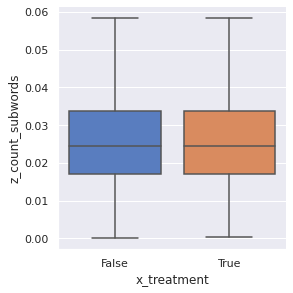

In [321]:
#first covariate by treatment

sns.set_theme(style="darkgrid")

f = sns.catplot(
    x = 'x_treatment', 
    y = 'z_count_subwords', 
    #row="class",
    #col = 'x_treatment',
    kind="box", 
    #orient="h", 
    height=4, 
    aspect=1, 
    palette="muted",
    data=df_cross_normalized,#df_cross_v0,
    showfliers = False
)

### Correlation Analysis Entropy

In [342]:
LIM = 0.1#500
S = 2

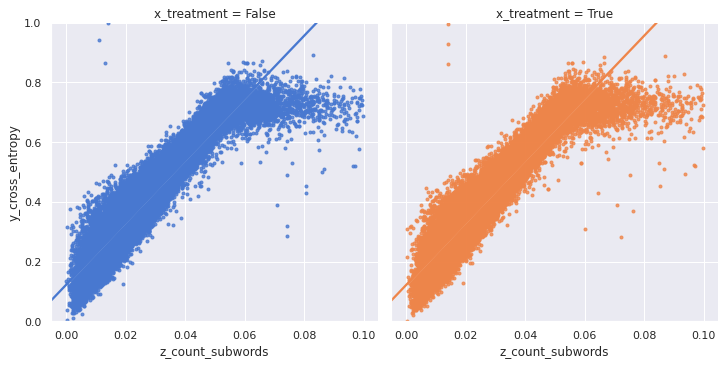

In [343]:
#Plotting the means
sns.set_theme(color_codes=True,style="darkgrid")
g = sns.lmplot(
    x="z_count_subwords", 
    y="y_cross_entropy", 
    #data=df_cross_v0[df_cross_v0['z_count_subwords']<= LIM],
    data=df_cross_normalized[df_cross_normalized['z_count_subwords'] <= LIM],
    col='x_treatment',
    hue='x_treatment',
    #x_estimator=np.mean,
    truncate=False,
    markers=[".", "."],
    palette="muted", 
    #ylim=(0, LIM),
    #color="m", 
    #height=7
)
g.set(ylim=(0, 1))

In [344]:
sns.set_theme(style="darkgrid")

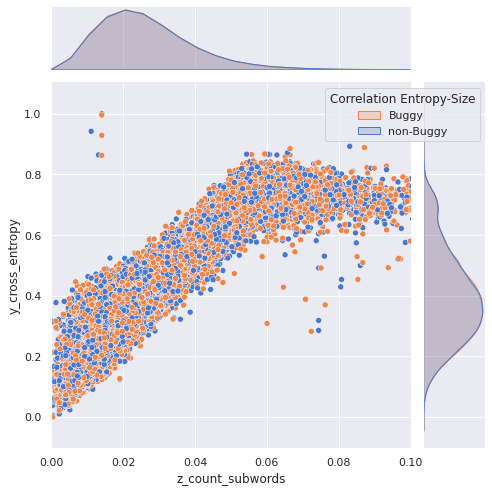

In [345]:
f = sns.jointplot(x="z_count_subwords", y="y_cross_entropy", 
                  data=df_cross_normalized,
                  hue='x_treatment',
                  kind="scatter", 
                  #truncate=False,
                  xlim=(0, LIM), 
                  #ylim=(0, 12),
                  color="m", 
                  palette="muted",
                  height=7,
                  legend=False
                 )
plt.legend(
    title="Correlation Entropy-Size", 
    #loc='upper left', 
    labels=params1['new_labels']
)

In [347]:
df_buggy_cross_normalized = df_cross_normalized.loc[lambda row: row['x_treatment'] == True  ].copy()
df_nonbuggy_cross_normalized = df_cross_normalized.loc[lambda row: row['x_treatment'] == False  ].copy()

In [348]:
df_nonbuggy_cross_v0.describe()

y_cross_entropy  z_count_subwords         z_wmc  z_totalMethodsQty  \
count     64722.000000      64722.000000  64722.000000            64722.0   
mean          6.148851        185.643460      2.479837                1.0   
std           1.513355         64.668787      1.307252                0.0   
min           2.118368         68.000000      1.000000                1.0   
25%           5.047101        143.000000      1.000000                1.0   
50%           5.987264        176.000000      2.000000                1.0   
75%           7.099688        216.000000      3.000000                1.0   
max          12.283474       4448.000000     16.000000                1.0   

       z_staticMethodsQty  z_publicMethodsQty  z_privateMethodsQty  \
count        64722.000000        64722.000000         64722.000000   
mean             0.128349            0.704305             0.207905   
std              0.334481            0.456358             0.405811   
min              0.000000            0.000000             0.000000   
25%              0.000000            0.000000             0.000000   
50%              0.000000            1.000000             0.000000   
75%              0.000000            1.000000             0.000000   
max              1.000000            1.000000             1.000000   

       z_protectedMethodsQty  z_defaultMethodsQty  z_abstractMethodsQty  ...  \
count           64722.000000         64722.000000          64722.000000  ...   
mean                0.065418             0.022373              0.792095  ...   
std                 0.247264             0.147893              0.405811  ...   
min                 0.000000             0.000000              0.000000  ...   
25%                 0.000000             0.000000              1.000000  ...   
50%                 0.000000             0.000000              1.000000  ...   
75%                 0.000000             0.000000              1.000000  ...   
max                 1.000000             1.000000              1.000000  ...   

       z_numbersQty  z_assignmentsQty  z_mathOperationsQty  z_variablesQty  \
count  64722.000000      64722.000000         64722.000000    64722.000000   
mean       0.912317          1.887503             0.571645        1.234325   
std        1.718701          1.582152             1.361637        1.162712   
min        0.000000          0.000000             0.000000        0.000000   
25%        0.000000          1.000000             0.000000        0.000000   
50%        0.000000          2.000000             0.000000        1.000000   
75%        1.000000          3.000000             0.000000        2.000000   
max       39.000000         19.000000            21.000000       10.000000   

       z_maxNestedBlocksQty  z_anonymousClassesQty  z_innerClassesQty  \
count          64722.000000           64722.000000       64722.000000   
mean               1.017459               0.023207           0.000355   
std                0.830316               0.157581           0.020422   
min                0.000000               0.000000           0.000000   
25%                0.000000               0.000000           0.000000   
50%                1.000000               0.000000           0.000000   
75%                1.000000               0.000000           0.000000   
max                6.000000               3.000000           2.000000   

       z_lambdasQty  z_uniqueWordsQty  z_modifiers  
count  64722.000000      64722.000000      64722.0  
mean       0.006149         11.341399          1.0  
std        0.093479          5.001736          0.0  
min        0.000000          3.000000          1.0  
25%        0.000000          8.000000          1.0  
50%        0.000000         10.000000          1.0  
75%        0.000000         13.000000          1.0  
max        5.000000        336.000000          1.0  

[8 rows x 39 columns]

In [350]:
#export
def corrcoef(v,w):
    x = np.corrcoef(v,w)
    x = np.round(x[0][1],3)
    return x

In [351]:
#General Correlation
corrcoef(df_cross_normalized.y_cross_entropy.values,df_cross_normalized.z_count_subwords.values)

0.87

In [352]:
#Buggy Correlation
corrcoef(df_buggy_cross_normalized.y_cross_entropy.values, df_buggy_cross_normalized.z_count_subwords.values)

0.873

In [353]:
#NonBuggy Correlation
corrcoef(df_nonbuggy_cross_normalized.y_cross_entropy.values, df_nonbuggy_cross_normalized.z_count_subwords.values)

0.867

In [349]:
#ax = df_buggy_cross_v0.loc[lambda row: row["z_count_subwords"] < LIM ].plot.scatter(x="z_count_subwords", y="y_cross_entropy", s=S, color="DarkBlue", label="Buggy")
#df_nonbuggy_cross_v0.loc[lambda row: row["z_count_subwords"] < LIM ].plot.scatter(x="z_count_subwords", y="y_cross_entropy", s=S, color="Green", label="non-Buggy", alpha=0.3, ax=ax)

### Correlation Analysis Error Taxonomy

In [354]:
taxonomy = ['y_blocks',
'y_exceptions','y_oop','y_tests',
'y_declarations','y_conditionals','y_loops',
'y_operators','y_datatypes','y_extra_tokens']

In [355]:
df_buggy_error_tax_normalized  = df_error_tax_normalized.loc[lambda row: row['x_treatment'] == True  ].copy()
df_nonbuggy_error_tax_normalized  = df_error_tax_normalized.loc[lambda row: row['x_treatment'] == False  ].copy()

In [356]:
#General Correlation
for i in taxonomy:
    df_temp = df_error_tax_normalized[[i,'z_count_subwords']].dropna(axis=0, how='any')
    logging.info( str(i)+':' + str( corrcoef(df_temp[i].values, df_temp.z_count_subwords.values) ) )

2021-07-18 04:15:50,979 : INFO : y_blocks:-0.102
2021-07-18 04:15:50,982 : INFO : y_exceptions:0.013
2021-07-18 04:15:50,991 : INFO : y_oop:0.029
2021-07-18 04:15:50,995 : INFO : y_tests:-0.046
2021-07-18 04:15:50,999 : INFO : y_declarations:-0.003
2021-07-18 04:15:51,003 : INFO : y_conditionals:0.03
2021-07-18 04:15:51,007 : INFO : y_loops:0.1
2021-07-18 04:15:51,011 : INFO : y_operators:0.015
2021-07-18 04:15:51,015 : INFO : y_datatypes:-0.043
2021-07-18 04:15:51,019 : INFO : y_extra_tokens:0.025


In [357]:
#Buggy Correlation
for i in taxonomy:
    df_temp = df_buggy_error_tax_normalized[[i,'z_count_subwords']].dropna(axis=0, how='any')
    logging.info( str(i)+':' + str( corrcoef(df_temp[i].values, df_temp.z_count_subwords.values) ) )

2021-07-18 04:16:06,326 : INFO : y_blocks:-0.103
2021-07-18 04:16:06,330 : INFO : y_exceptions:0.013
2021-07-18 04:16:06,333 : INFO : y_oop:0.028
2021-07-18 04:16:06,336 : INFO : y_tests:-0.047
2021-07-18 04:16:06,339 : INFO : y_declarations:-0.004
2021-07-18 04:16:06,342 : INFO : y_conditionals:0.026
2021-07-18 04:16:06,345 : INFO : y_loops:0.098
2021-07-18 04:16:06,349 : INFO : y_operators:0.018
2021-07-18 04:16:06,352 : INFO : y_datatypes:-0.044
2021-07-18 04:16:06,355 : INFO : y_extra_tokens:0.023


In [358]:
#nonBuggy Correlation
for i in taxonomy:
    df_temp = df_nonbuggy_error_tax_normalized[[i,'z_count_subwords']].dropna(axis=0, how='any')
    logging.info( str(i)+':' + str( corrcoef(df_temp[i].values, df_temp.z_count_subwords.values) ) )

2021-07-18 04:16:07,942 : INFO : y_blocks:-0.102
2021-07-18 04:16:07,946 : INFO : y_exceptions:0.014
2021-07-18 04:16:07,949 : INFO : y_oop:0.029
2021-07-18 04:16:07,951 : INFO : y_tests:-0.047
2021-07-18 04:16:07,955 : INFO : y_declarations:-0.003
2021-07-18 04:16:07,958 : INFO : y_conditionals:0.033
2021-07-18 04:16:07,961 : INFO : y_loops:0.101
2021-07-18 04:16:07,964 : INFO : y_operators:0.013
2021-07-18 04:16:07,967 : INFO : y_datatypes:-0.043
2021-07-18 04:16:07,970 : INFO : y_extra_tokens:0.027


### Bootstrapping of Means [z_count_subwords]

In [362]:
#General Bootstrapping
bs_cross = bootstrapping( df_cross_v0.z_count_subwords.values , np.mean, 10000, columns=['bs_z_count_subwords'])

2021-07-18 04:18:55,344 : INFO : Empirical Mean: 185.4076280090232
2021-07-18 04:18:55,346 : INFO : Bootstrapped Mean: 185.40494933407498


In [363]:
confidence_intervals( bs_cross.bs_z_count_subwords.values )

2021-07-18 04:18:55,353 : INFO : (185.4014010445459, 185.40849762360406)


(185.4014010445459, 185.40849762360406)

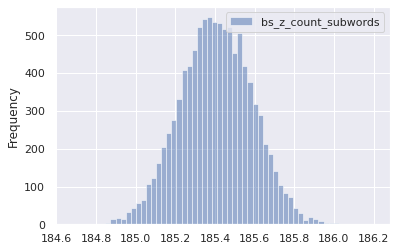

In [364]:
sns.set_theme(style="darkgrid")
bs_cross.plot.hist(alpha=0.5, bins=60)

In [365]:
bs_buggy_error_tax_v0  =  bootstrapping(df_error_tax_v0.z_count_subwords.values , np.mean, 5000, columns=['z_count_subwords_control'])
bs_nonbuggy_error_tax_v0  = bootstrapping(df_error_tax_v0.z_count_subwords.values , np.mean, 5000, columns=['z_count_subwords_treatment'])

2021-07-18 04:19:16,172 : INFO : Empirical Mean: 185.4076280090232
2021-07-18 04:19:16,173 : INFO : Bootstrapped Mean: 185.41008541299712
2021-07-18 04:19:21,045 : INFO : Empirical Mean: 185.4076280090232
2021-07-18 04:19:21,046 : INFO : Bootstrapped Mean: 185.40695108463893


In [366]:
df_error_tax_bs = pd.concat([bs_buggy_error_tax_v0,bs_nonbuggy_error_tax_v0],axis=1)

In [367]:
df_error_tax_bs.head(1)

z_count_subwords_control  z_count_subwords_treatment
0                185.764222                  185.315449

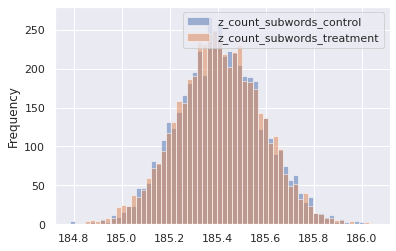

In [368]:
sns.set_theme(style="darkgrid")
df_error_tax_bs.plot.hist(alpha=0.5, bins=60)

### Empirical PDF and CDF [z_count_subwords]

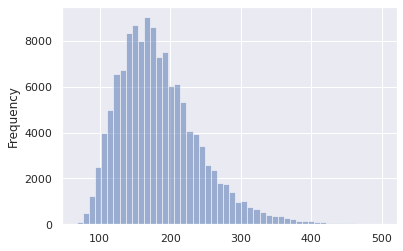

In [161]:
# Empirical PDF or Probability Density Function
sns.set_theme(style="darkgrid")
df_cross_v0['z_count_subwords'].loc[lambda row: row < LIM ].plot.hist(alpha=0.5, bins=50)

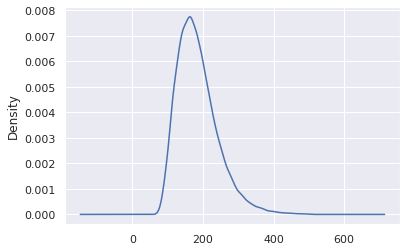

In [162]:
# PDF or Probability Density Function
sns.set_theme(style="darkgrid")
df_cross_v0['z_count_subwords'].loc[lambda row: row < LIM ].plot.kde()

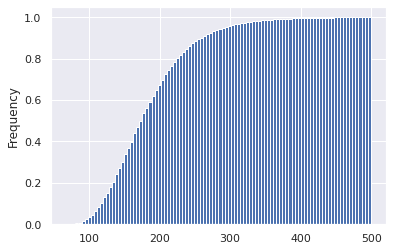

In [163]:
#Empirical CDF demonstrate that 50% of methods in our sample have around 180 or less tokens. 
sns.set_theme(style="darkgrid")
df_cross_v0['z_count_subwords'].loc[lambda row: row < LIM ].plot.hist( 
    cumulative = True,
    density =1,
    bins=100
)

# Second Covariate Analysis: SE Metrics
> This module provides a tool for computing metrics (from static analysis) for python source code using Using <a href="https://github.com/mauricioaniche/ck">CK Package</a>

CK is a java package (jar) which is going to be executed from terminal. It requires the code which is going to be analyzed to be located at <i>physical</i> files. For that reason, the dataset is going to be used to produce some <i>.java</i> files.

Each record, corresponds to a individual class. When working with method-level snippets, "articial" classes are created for performing the analysis.

In [401]:
#export
from subprocess import *
import os
import shutil

In [55]:
Popen

subprocess.Popen

In [56]:
# export
def write_dataset_to_files(df_series, destination_path):
    """
    Function to generate .java files.
    
    Params:
    # df_series: Pandas Series (DataFrame column) with the source code records.
    # destination_path: (str) Absolute path to be used as directory for the generated files.
    
    Returns:
    
    Collection of paths for the corresponding java files.
    
    """
    java_template = 'public class <class_name>{\n    <code_snippet>\n}'
    
    if not os.path.exists(destination_path):
        logging.info('Creating directory.')
        os.mkdir(destination_path)
    
    logging.info("Generating physical .java files.")
    
    file_paths = []
    for idx, value in df_series.iteritems():
        class_name = f'ClassRecord{idx}'
        code = java_template.replace('<class_name>', class_name)
        code = code.replace('<code_snippet>', value)
        file_path = f'{destination_path}/{class_name}.java'
        with open(file_path, 'w') as file:
            file.write(code)
            file_paths.append(file_path)
            
    return file_paths

In [57]:
# export
def jarWrapper(*args):
    process = Popen(['java', '-jar']+list(args), stdout=PIPE, stderr=PIPE)
    ret = []
    while process.poll() is None:
        line = process.stdout.readline()
        if line != '' and line.endswith(b'\n'):
            ret.append(line[:-1])
    stdout, stderr = process.communicate()
    
    ret += stdout.split(b'\n')
    if stderr != '':
        ret += stderr.split(b'\n')
        
    if '' in ret:
        ret.remove('')
    return ret

In [58]:
# export
class JavaAnalyzer():
    """
    Class get metrics f
    """
    def __init__(self, ck_jar_path):
        self.ck_jar_path = ck_jar_path
    
    def compute_metrics(self, df_series, files_destination_path):
        """
        Computes metrics for a pandas series of java source code snippets
        
        Params
        # df_series: Pandas series (df column) containing java source snippets
        # files_destination_path: Path indicating where the physical .java files are going to be created (for metrics computation)
        
        Returns:
        
        Pandas Dataframe containing metrics
        
        """
        file_paths = write_dataset_to_files(df_series, files_destination_path)
        self.__call_ck_package(files_destination_path)
        metrics_df = self.__get_metrics_df()
        self.__remove_csv_files()
        self.__remove_tmp_java_files(file_paths)
        
        return metrics_df
        
    def __call_ck_package(self, files_path):
        """
        Performs call to external .jar package.
        """
        args = [self.ck_jar_path, files_path, 'false', '0', 'True']
        result = jarWrapper(*args)
        logging.info(f'CK package produced this output:\n{result}')
        
    def __get_metrics_df(self):
        """
        Reads report files (csv) generated by the CK package.
        
        Returns:
        
        Pandas Dataframe containing appropriate metrics
        """
        class_metrics_df = pd.read_csv('class.csv')
        # method_metrics_df = pd.read_csv('method.csv')

        # merged_df = pd.merge(left = class_metrics_df, right = method_metrics_df, left_on='file', right_on='file')

        appropriate_columns = ['file','class', 'wmc', 'totalMethodsQty', 'staticMethodsQty', 'publicMethodsQty', 'privateMethodsQty',
                          'protectedMethodsQty', 'defaultMethodsQty', 'abstractMethodsQty', 'finalMethodsQty','synchronizedMethodsQty',
                          'totalFieldsQty', 'staticFieldsQty', 'publicFieldsQty', 'privateFieldsQty', 'protectedFieldsQty',
                          'defaultFieldsQty', 'visibleFieldsQty', 'finalFieldsQty', 'synchronizedFieldsQty',
                          'nosi', 'loc', 'returnQty', 'loopQty', 'comparisonsQty', 'tryCatchQty', 'parenthesizedExpsQty',
                          'stringLiteralsQty', 'numbersQty', 'assignmentsQty', 'mathOperationsQty', 'variablesQty', 'maxNestedBlocksQty',
                          'anonymousClassesQty', 'innerClassesQty', 'lambdasQty', 'uniqueWordsQty', 'modifiers']

        class_metrics_df = class_metrics_df[appropriate_columns]

        return class_metrics_df
    
    def __remove_csv_files(self):
        """
        Removes files generated by CK package.
        """
        if os.path.exists('class.csv'):
            os.remove('class.csv')
        if os.path.exists('method.csv'):
            os.remove('method.csv')
        if os.path.exists('field.csv'):
            os.remove('field.csv')
            
    def __remove_tmp_java_files(self, paths):
        """
        Removes the temporary generated java files.
        """
        for file_path in paths:
            os.remove(file_path)

In [164]:
# Configuration for Second Covariate Analysis
def params2():
    return {
        'tokenizer':dvc_path / 'models/bpe/tokenizer-java-v1.json',
        'bug_entropy':dvc_path / 'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/bug_fix_cross_entropy_z_v1.jsonl',
        'bug_taxonomy':dvc_path / 'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/bug_fix_error_taxonomy_z_v1.jsonl',
        'output': dvc_path / 'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/',
        'ck_jar_path': dvc_path / 'nbs/tools/ck-metrics.jar',
        'physical_files_path': dvc_path/'datax/data_z_covariates/Model-R 0.0.0 rnn_layers1_vocab10000_embed256_units1024/test_metrics',
        'new_labels' : ['Buggy', 'non-Buggy']
    }

In [165]:
params2 = params2()

In [166]:
str(params2['ck_jar_path'])

'../dvc-icodegen/nbs/tools/ck-metrics.jar'

In [167]:
params2['ck_jar_path']

PosixPath('../dvc-icodegen/nbs/tools/ck-metrics.jar')

In [126]:
df_cross_v0.head(1)

transformed_code  y_cross_entropy  \
0  <private> <void> success<(>io.netty.channel.Ch...          6.00622   

   x_treatment                                      original_code  \
0        False  private void success(io.netty.channel.Channel ...   

   z_count_subwords                                               file  
0               177  ../dvc-icodegen/nbs/nbs_experiments/results/an...

In [65]:
df_error_tax_v0.head(1)

y_blocks  y_exceptions     y_oop  y_tests  y_declarations  y_conditionals  \
0  0.016686           NaN  0.000009      NaN    3.518000e-07             NaN   

   y_loops  y_operators  y_datatypes  y_extra_tokens  \
0      NaN     0.000316          NaN        0.189851   

                                       original_code  \
0  private void success(io.netty.channel.Channel ...   

                                    transformed_code  x_treatment  \
0  <private> <void> success<(>io.netty.channel.Ch...        False   

   z_count_subwords  
0               177

In [66]:
java_analyzer = JavaAnalyzer( params2['ck_jar_path'] )

In [79]:
#Updates df_cross_v0
#Becareful to not recompute this code, make sure to erase the folder afterwards
df_cross_v0_paths = write_dataset_to_files( df_cross_v0['original_code'], params2['physical_files_path'] )

2021-07-06 20:50:25,036 : INFO : Generating physical .java files.


In [114]:
df_cross_v0['original_code'][0]

'private void success(io.netty.channel.Channel channel) {\n    org.mycat.netty.mysql.MySQLHandshakeHandler.logger.debug("success info return form MySQLHandshakeHandler");\n    io.netty.buffer.ByteBuf out = channel.alloc().buffer();\n    org.mycat.netty.mysql.OK ok = new org.mycat.netty.mysql.OK();\n    ok.sequenceId = 2;\n    ok.setStatusFlag(Flags.SERVER_STATUS_AUTOCOMMIT);\n    out.writeBytes(ok.toPacket());\n    channel.writeAndFlush(out);\n}'

In [81]:
df_cross_v0_paths[0]

'../dvc-icodegen/nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/test_metrics/ClassRecord0.java'

In [127]:
file_path = ['/home/jovyan/work/nbs/'+i for i in df_cross_v0_paths]

In [220]:
len(file_path)

129444

In [129]:
#updating main frames with filepaths
df_cross_v0['file'] = file_path

In [370]:
df_error_tax_v0['file'] = file_path

In [130]:
df_cross_v0.head(1)

transformed_code  y_cross_entropy  \
0  <private> <void> success<(>io.netty.channel.Ch...          6.00622   

   x_treatment                                      original_code  \
0        False  private void success(io.netty.channel.Channel ...   

   z_count_subwords                                               file  
0               177  /home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...

In [ ]:
#renaming just in case
df_cross_v0.rename(columns = {'file':'file'}, inplace = True)

In [131]:
assert len(df_cross_v0_paths) == len(df_error_tax_v0)

In [95]:
#TODO
#df_cross_v0_java_metrics should change the name to something about the covariate
df_cross_v0_java_metrics = java_analyzer.compute_metrics( df_cross_v0['original_code'], params2['physical_files_path'] )

2021-07-06 21:58:35,544 : INFO : Generating physical .java files.
2021-07-06 23:29:06,703 : INFO : CK package produced this output:
[b'', b'log4j:WARN No appenders could be found for logger (com.github.mauricioaniche.ck.CK).', b'log4j:WARN Please initialize the log4j system properly.', b'']


In [235]:
df_cross_v0_java_metrics.shape

(132540, 39)

### Anonymous Class Treatment

In [229]:
#tst
cnt = Counter()
redundant_class = [] #Anonimous Classes Paths

In [230]:
#tst
for path in file_path:
    instances = df_cross_v0_java_metrics[df_cross_v0_java_metrics['file']==path].shape[0]
    cnt[path] += instances
    if instances > 1:
        redundant_class.append([instances,path])

In [245]:
len(redundant_class)

2904

In [249]:
redundant_class[:2]

[[2,
  '/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/test_metrics/ClassRecord170.java'],
 [2,
  '/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/test_metrics/ClassRecord171.java']]

In [234]:
len(cnt[''])

129444

In [265]:
#Non anonimous clases
temporal = [k for k in cnt if cnt[k]==1]

In [266]:
temporal[0]

'/home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_experiments/results/analyses/rnn_layers1_vocab10000_embed256_units1024/test_metrics/ClassRecord0.java'

In [267]:
len(temporal) #Total Number of Samples without Anonymous Classes

126540

In [400]:
df_cross_v0_java_metrics_anony.shape

NameError: name 'df_cross_v0_java_metrics_anony' is not defined

In [259]:
df_cross_v0_java_metrics_anony.head(1)

file             class  wmc  \
18  /home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...  ClassRecord23299    4   

    totalMethodsQty  staticMethodsQty  publicMethodsQty  privateMethodsQty  \
18                1                 0                 0                  0   

    protectedMethodsQty  defaultMethodsQty  abstractMethodsQty  ...  \
18                    0                  1                   1  ...   

    numbersQty  assignmentsQty  mathOperationsQty  variablesQty  \
18           1               1                  0             0   

    maxNestedBlocksQty  anonymousClassesQty  innerClassesQty  lambdasQty  \
18                   1                    1                0           0   

    uniqueWordsQty  modifiers  
18              16          1  

[1 rows x 39 columns]

In [338]:
#Without Anonymous
df_cross_v0_java_metrics_base = df_cross_v0_java_metrics[df_cross_v0_java_metrics.file.isin( [i for i in temporal] )].copy()

In [339]:
df_cross_v0_java_metrics_base.shape

(126540, 39)

In [331]:
t = df_cross_v0_java_metrics_anony[ ~df_cross_v0_java_metrics_anony['class'].str.match( '^.*\$.*$' ) ] #Regular Expression to Find Cases

In [332]:
t.shape

(2904, 39)

In [337]:
t.head(1)

file             class  wmc  \
18  /home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...  ClassRecord23299    4   

    totalMethodsQty  staticMethodsQty  publicMethodsQty  privateMethodsQty  \
18                1                 0                 0                  0   

    protectedMethodsQty  defaultMethodsQty  abstractMethodsQty  ...  \
18                    0                  1                   1  ...   

    numbersQty  assignmentsQty  mathOperationsQty  variablesQty  \
18           1               1                  0             0   

    maxNestedBlocksQty  anonymousClassesQty  innerClassesQty  lambdasQty  \
18                   1                    1                0           0   

    uniqueWordsQty  modifiers  
18              16          1  

[1 rows x 39 columns]

In [340]:
df_cross_v0_java_metrics_base = pd.concat( [t,df_cross_v0_java_metrics_base] )

In [341]:
df_cross_v0_java_metrics_base.shape

(129444, 39)

In [342]:
df_cross_v0_java_metrics_base.head(1)

file             class  wmc  \
18  /home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...  ClassRecord23299    4   

    totalMethodsQty  staticMethodsQty  publicMethodsQty  privateMethodsQty  \
18                1                 0                 0                  0   

    protectedMethodsQty  defaultMethodsQty  abstractMethodsQty  ...  \
18                    0                  1                   1  ...   

    numbersQty  assignmentsQty  mathOperationsQty  variablesQty  \
18           1               1                  0             0   

    maxNestedBlocksQty  anonymousClassesQty  innerClassesQty  lambdasQty  \
18                   1                    1                0           0   

    uniqueWordsQty  modifiers  
18              16          1  

[1 rows x 39 columns]

In [344]:
assert df_cross_v0_java_metrics_base.shape[0] == len(file_path)

In [397]:
#saving
df_cross_v0_java_metrics.to_json(params2['output'] / 'ck-metrics-buggy.jsonl', orient="records", lines=True)

In [345]:
#Merging DataFrames
df_cross_v1_base = pd.merge( df_cross_v0, df_cross_v0_java_metrics_base, on = 'file' )

In [371]:
df_error_tax_v1_base = pd.merge(df_error_tax_v0, df_cross_v0_java_metrics_base, on = 'file' )

In [402]:
#export
def appropriate_columns_r() -> dict:
    return {
    'wmc':'z_wmc', 
    'totalMethodsQty':'z_totalMethodsQty', 
    'staticMethodsQty':'z_staticMethodsQty', 
    'publicMethodsQty':'z_publicMethodsQty', 
    'privateMethodsQty':'z_privateMethodsQty',
    'protectedMethodsQty':'z_protectedMethodsQty', 
    'defaultMethodsQty':'z_defaultMethodsQty', 
    'abstractMethodsQty':'z_abstractMethodsQty', 
    'finalMethodsQty':'z_finalMethodsQty',
    'synchronizedMethodsQty':'z_synchronizedMethodsQty',
    'totalFieldsQty':'z_totalFieldsQty', 
    'staticFieldsQty':'z_staticFieldsQty', 
    'publicFieldsQty':'z_publicFieldsQty', 
    'privateFieldsQty':'z_privateFieldsQty', 
    'protectedFieldsQty':'z_protectedFieldsQty',        
    'defaultFieldsQty':'z_defaultFieldsQty', 
    'visibleFieldsQty':'z_visibleFieldsQty', 
    'finalFieldsQty':'z_finalFieldsQty', 
    'synchronizedFieldsQty':'z_synchronizedFieldsQty',
    'nosi':'z_nosi', 
    'loc':'z_loc', 
    'returnQty':'z_returnQty', 
    'loopQty':'z_loopQty', 
    'comparisonsQty':'z_comparisonsQty', 
    'tryCatchQty':'z_tryCatchQty', 
    'parenthesizedExpsQty':'z_parenthesizedExpsQty',
    'stringLiteralsQty':'z_stringLiteralsQty', 
    'numbersQty':'z_numbersQty', 
    'assignmentsQty':'z_assignmentsQty', 
    'mathOperationsQty':'z_mathOperationsQty', 
    'variablesQty':'z_variablesQty', 
    'maxNestedBlocksQty':'z_maxNestedBlocksQty',
    'anonymousClassesQty':'z_anonymousClassesQty', 
    'innerClassesQty':'z_innerClassesQty', 
    'lambdasQty':'z_lambdasQty', 
    'uniqueWordsQty':'z_uniqueWordsQty', 
    'modifiers':'z_modifiers'
}

In [403]:
appropriate_columns_r = appropriate_columns_r()

In [347]:
df_cross_v1_base.rename(columns = appropriate_columns_r, inplace = True)

In [373]:
df_error_tax_v1_base.rename(columns = appropriate_columns_r, inplace = True)

In [348]:
df_cross_v1_base.head(1)

transformed_code  y_cross_entropy  \
0  <private> <void> success<(>io.netty.channel.Ch...          6.00622   

   x_treatment                                      original_code  \
0        False  private void success(io.netty.channel.Channel ...   

   z_count_subwords                                               file  \
0               177  /home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...   

          class  z_wmc  z_totalMethodsQty  z_staticMethodsQty  ...  \
0  ClassRecord0      1                  1                   0  ...   

   z_numbersQty  z_assignmentsQty  z_mathOperationsQty  z_variablesQty  \
0             1                 3                    0               2   

   z_maxNestedBlocksQty  z_anonymousClassesQty  z_innerClassesQty  \
0                     0                      0                  0   

   z_lambdasQty  z_uniqueWordsQty  z_modifiers  
0             0                 8            1  

[1 rows x 44 columns]

In [374]:
df_error_tax_v1_base.head(1)

y_blocks  y_exceptions     y_oop  y_tests  y_declarations  y_conditionals  \
0  0.016686           NaN  0.000009      NaN    3.518000e-07             NaN   

   y_loops  y_operators  y_datatypes  y_extra_tokens  ... z_numbersQty  \
0      NaN     0.000316          NaN        0.189851  ...            1   

  z_assignmentsQty  z_mathOperationsQty  z_variablesQty z_maxNestedBlocksQty  \
0                3                    0               2                    0   

  z_anonymousClassesQty  z_innerClassesQty  z_lambdasQty  z_uniqueWordsQty  \
0                     0                  0             0                 8   

   z_modifiers  
0            1  

[1 rows x 53 columns]

In [278]:
df_cross_v1_anony = pd.merge( df_cross_v0, df_cross_v0_java_metrics_anony, on = 'file' )

In [398]:
df_error_tax_v1_anony = pd.merge( df_error_tax_v0, df_cross_v0_java_metrics_anony, on = 'file' )

In [279]:
df_cross_v1_anony.shape

(6000, 44)

In [284]:
df_cross_v1_anony.rename(columns = appropriate_columns, inplace = True)

In [285]:
df_cross_v1_anony.head(1)

transformed_code  y_cross_entropy  \
0  <public> <static> bolts.Task<lesser>com.<do>un...         6.765714   

   x_treatment                                      original_code  \
0        False  public static bolts.Task<com.dounets.vchat.net...   

   z_count_subwords                                               file  \
0               196  /home/jovyan/work/nbs/../dvc-icodegen/nbs/nbs_...   

                       class  z_wmc  z_totalMethodsQty  z_staticMethodsQty  \
0  ClassRecord170$Anonymous1      1                  1                   0   

   ...  z_numbersQty  z_assignmentsQty  z_mathOperationsQty  z_variablesQty  \
0  ...             0                 0                    0               0   

   z_maxNestedBlocksQty  z_anonymousClassesQty  z_innerClassesQty  \
0                     0                      0                  0   

   z_lambdasQty  z_uniqueWordsQty  z_modifiers  
0             0                 1           -1  

[1 rows x 44 columns]

In [401]:
#Savings
df_error_tax_v1_base.to_json(params2['output'] / 'bug_fix_error_taxonomy_z_v1.jsonl', orient="records", lines=True)
df_cross_v1_base.to_json(params2['output'] / 'bug_fix_cross_entropy_z_v1.jsonl', orient="records", lines=True)

In [402]:
df_cross_v1_anony.to_json(params2['output'] / 'bug_fix_cross_anony_z_v1.jsonl', orient="records", lines=True)
df_error_tax_v1_anony.to_json(params2['output'] / 'bug_fix_error_taxonomy_anony_z_v1.jsonl', orient="records", lines=True)

# Descriptive Statistics

hierarchical:
- [hierarchical] wmc: Weight Method Class or McCabe's complexity

code size:
- [code size] loc: Lines of code
- [code size] Number of methods: Count the number of fields, both total (totalMethodsQty) and specific (i.e., static, public, abstract, private, protected, default, final, and synchronized)
- [code size] totalMethodsQty:
- [code size] staticMethodsQty
- [code size] publicMethodsQty
- [code size] privateMethodsQty
- [code size] protectedMethodsQty
- [code size] defaultMethodsQty
- [code size] abstractMethodsQty
- [code size] finalMethodsQty
- [code size] synchronizedMethodsQty
- [code size] Number of fields: Count the number of fields, both total (totalFieldsQty) and specific (i.e., static, public, private, protected, default, final, and synchronized)
- [code size] totalFieldsQty
- [code size] staticFieldsQty
- [code size] publicFieldsQty
- [code size] privateFieldsQty
- [code size] protectedFieldsQty
- [code size] defaultFieldsQty
- [code size] visibleFieldsQty
- [code size] finalFieldsQty
- [code size] synchronizedFieldsQty
- [code size] anonymousClassesQty: Number of anonymous classes
- [code size] innerClassesQty: Number of inner classes
- [code size] lambdasQty: Number of lambda expressions

structural:
- [structural] returnQty: Number of return instructions
- [structural] loopQty: Number of loops (i.e., for, while, do while, enhanced for).
- [structural] comparisonsQty: Number of comparisons (i.e., == and !=)
- [structural] tryCatchQty: Number of try/catch blocks
- [structural] parenthesizedExpsQty: The number of expressions inside parenthesis
- [structural] nosi: number of invocations to static methods. It can only count the ones that can be resolved by the JDT.
- [structural] assignmentsQty
- [structural] mathOperationsQty: The number of math operations (times, divide, remainder, plus, minus, left shit, right shift).
- [structural] variablesQty: Number of declared variables
- [structural] maxNestedBlocksQty: The highest number of blocks nested together.
- [structural] stringLiteralsQty: Number of string literals
- [structural] numbersQty: Number of numeric literals
- [structural] modifiers: public/abstract/private/protected/native modifiers of classes/methods

word size:
- [word size] uniqueWordsQty: Number of unique words: Number of unique words in the source code. At method level, it only uses the method body as input. At class level, it uses the entire body of the class as metrics. The algorithm basically counts the number of words in a method/class, after removing Java keywords.


In [170]:
df_cross_v1_base = pd.read_json(params2['bug_entropy'], orient="records", lines=True)

In [188]:
df_error_tax_v1_base = pd.read_json(params2['bug_taxonomy'], orient="records", lines=True)

## Entropy Analysis 

In [171]:
df_cross_v1_base.describe()

y_cross_entropy  z_count_subwords          z_wmc  z_totalMethodsQty  \
count    129444.000000     129444.000000  129444.000000           129444.0   
mean          6.142502        185.407628       2.482417                1.0   
std           1.510858         64.357274       1.309905                0.0   
min           2.066005         68.000000       1.000000                1.0   
25%           5.038853        143.000000       1.000000                1.0   
50%           5.982966        176.000000       2.000000                1.0   
75%           7.085069        216.000000       3.000000                1.0   
max          12.283474       4465.000000      18.000000                1.0   

       z_staticMethodsQty  z_publicMethodsQty  z_privateMethodsQty  \
count       129444.000000       129444.000000        129444.000000   
mean             0.128449            0.704490             0.207634   
std              0.334591            0.456273             0.405615   
min              0.000000            0.000000             0.000000   
25%              0.000000            0.000000             0.000000   
50%              0.000000            1.000000             0.000000   
75%              0.000000            1.000000             0.000000   
max              1.000000            1.000000             1.000000   

       z_protectedMethodsQty  z_defaultMethodsQty  z_abstractMethodsQty  ...  \
count          129444.000000        129444.000000         129444.000000  ...   
mean                0.065441             0.022434              0.792366  ...   
std                 0.247304             0.148092              0.405615  ...   
min                 0.000000             0.000000              0.000000  ...   
25%                 0.000000             0.000000              1.000000  ...   
50%                 0.000000             0.000000              1.000000  ...   
75%                 0.000000             0.000000              1.000000  ...   
max                 1.000000             1.000000              1.000000  ...   

        z_numbersQty  z_assignmentsQty  z_mathOperationsQty  z_variablesQty  \
count  129444.000000     129444.000000        129444.000000   129444.000000   
mean        0.913654          1.884583             0.571336        1.232247   
std         1.720107          1.580910             1.363303        1.161180   
min         0.000000          0.000000             0.000000        0.000000   
25%         0.000000          1.000000             0.000000        0.000000   
50%         0.000000          2.000000             0.000000        1.000000   
75%         1.000000          3.000000             0.000000        2.000000   
max        41.000000         19.000000            21.000000       11.000000   

       z_maxNestedBlocksQty  z_anonymousClassesQty  z_innerClassesQty  \
count         129444.000000          129444.000000      129444.000000   
mean               1.018572               0.023122           0.000348   
std                0.830400               0.157225           0.020232   
min                0.000000               0.000000           0.000000   
25%                0.000000               0.000000           0.000000   
50%                1.000000               0.000000           0.000000   
75%                1.000000               0.000000           0.000000   
max                6.000000               4.000000           2.000000   

        z_lambdasQty  z_uniqueWordsQty  z_modifiers  
count  129444.000000     129444.000000     129444.0  
mean        0.006080         11.336732          1.0  
std         0.092444          4.994894          0.0  
min         0.000000          3.000000          1.0  
25%         0.000000          8.000000          1.0  
50%         0.000000         10.000000          1.0  
75%         0.000000         13.000000          1.0  
max         5.000000        336.000000          1.0  

[8 rows x 39 columns]

In [287]:
df_cross_v1_anony.describe()

y_cross_entropy  z_count_subwords        z_wmc  z_totalMethodsQty  \
count      6000.000000       6000.000000  6000.000000        6000.000000   
mean          7.147433        216.791333     1.402833           1.028667   
std           1.347864         55.503041     0.748544           0.363594   
min           3.698782         91.000000     0.000000           0.000000   
25%           6.142089        177.000000     1.000000           1.000000   
50%           7.079727        212.500000     1.000000           1.000000   
75%           8.096434        250.000000     2.000000           1.000000   
max          10.829941        621.000000     5.000000           4.000000   

       z_staticMethodsQty  z_publicMethodsQty  z_privateMethodsQty  \
count         6000.000000         6000.000000          6000.000000   
mean             0.040167            0.834833             0.115333   
std              0.196366            0.535040             0.319450   
min              0.000000            0.000000             0.000000   
25%              0.000000            1.000000             0.000000   
50%              0.000000            1.000000             0.000000   
75%              0.000000            1.000000             0.000000   
max              1.000000            4.000000             1.000000   

       z_protectedMethodsQty  z_defaultMethodsQty  z_abstractMethodsQty  ...  \
count            6000.000000          6000.000000           6000.000000  ...   
mean                0.066500             0.012000              0.928667  ...   
std                 0.263482             0.111914              0.477441  ...   
min                 0.000000             0.000000              0.000000  ...   
25%                 0.000000             0.000000              1.000000  ...   
50%                 0.000000             0.000000              1.000000  ...   
75%                 0.000000             0.000000              1.000000  ...   
max                 3.000000             2.000000              4.000000  ...   

       z_numbersQty  z_assignmentsQty  z_mathOperationsQty  z_variablesQty  \
count   6000.000000       6000.000000          6000.000000     6000.000000   
mean       0.225167          0.616333             0.089333        0.374500   
std        0.661972          0.951289             0.409122        0.701901   
min        0.000000          0.000000             0.000000        0.000000   
25%        0.000000          0.000000             0.000000        0.000000   
50%        0.000000          0.000000             0.000000        0.000000   
75%        0.000000          1.000000             0.000000        1.000000   
max       11.000000          8.000000             7.000000        6.000000   

       z_maxNestedBlocksQty  z_anonymousClassesQty  z_innerClassesQty  \
count           6000.000000            6000.000000        6000.000000   
mean               0.293000               0.508167           0.007833   
std                0.522682               0.544655           0.095430   
min                0.000000               0.000000           0.000000   
25%                0.000000               0.000000           0.000000   
50%                0.000000               0.000000           0.000000   
75%                1.000000               1.000000           0.000000   
max                3.000000               4.000000           2.000000   

       z_lambdasQty  z_uniqueWordsQty  z_modifiers  
count   6000.000000       6000.000000  6000.000000  
mean       0.001167          6.972000    -0.024167  
std        0.034139          4.350368     0.995865  
min        0.000000          0.000000    -1.000000  
25%        0.000000          4.000000    -1.000000  
50%        0.000000          6.000000    -1.000000  
75%        0.000000          9.000000     1.000000  
max        1.000000         28.000000     1.000000  

[8 rows x 39 columns]

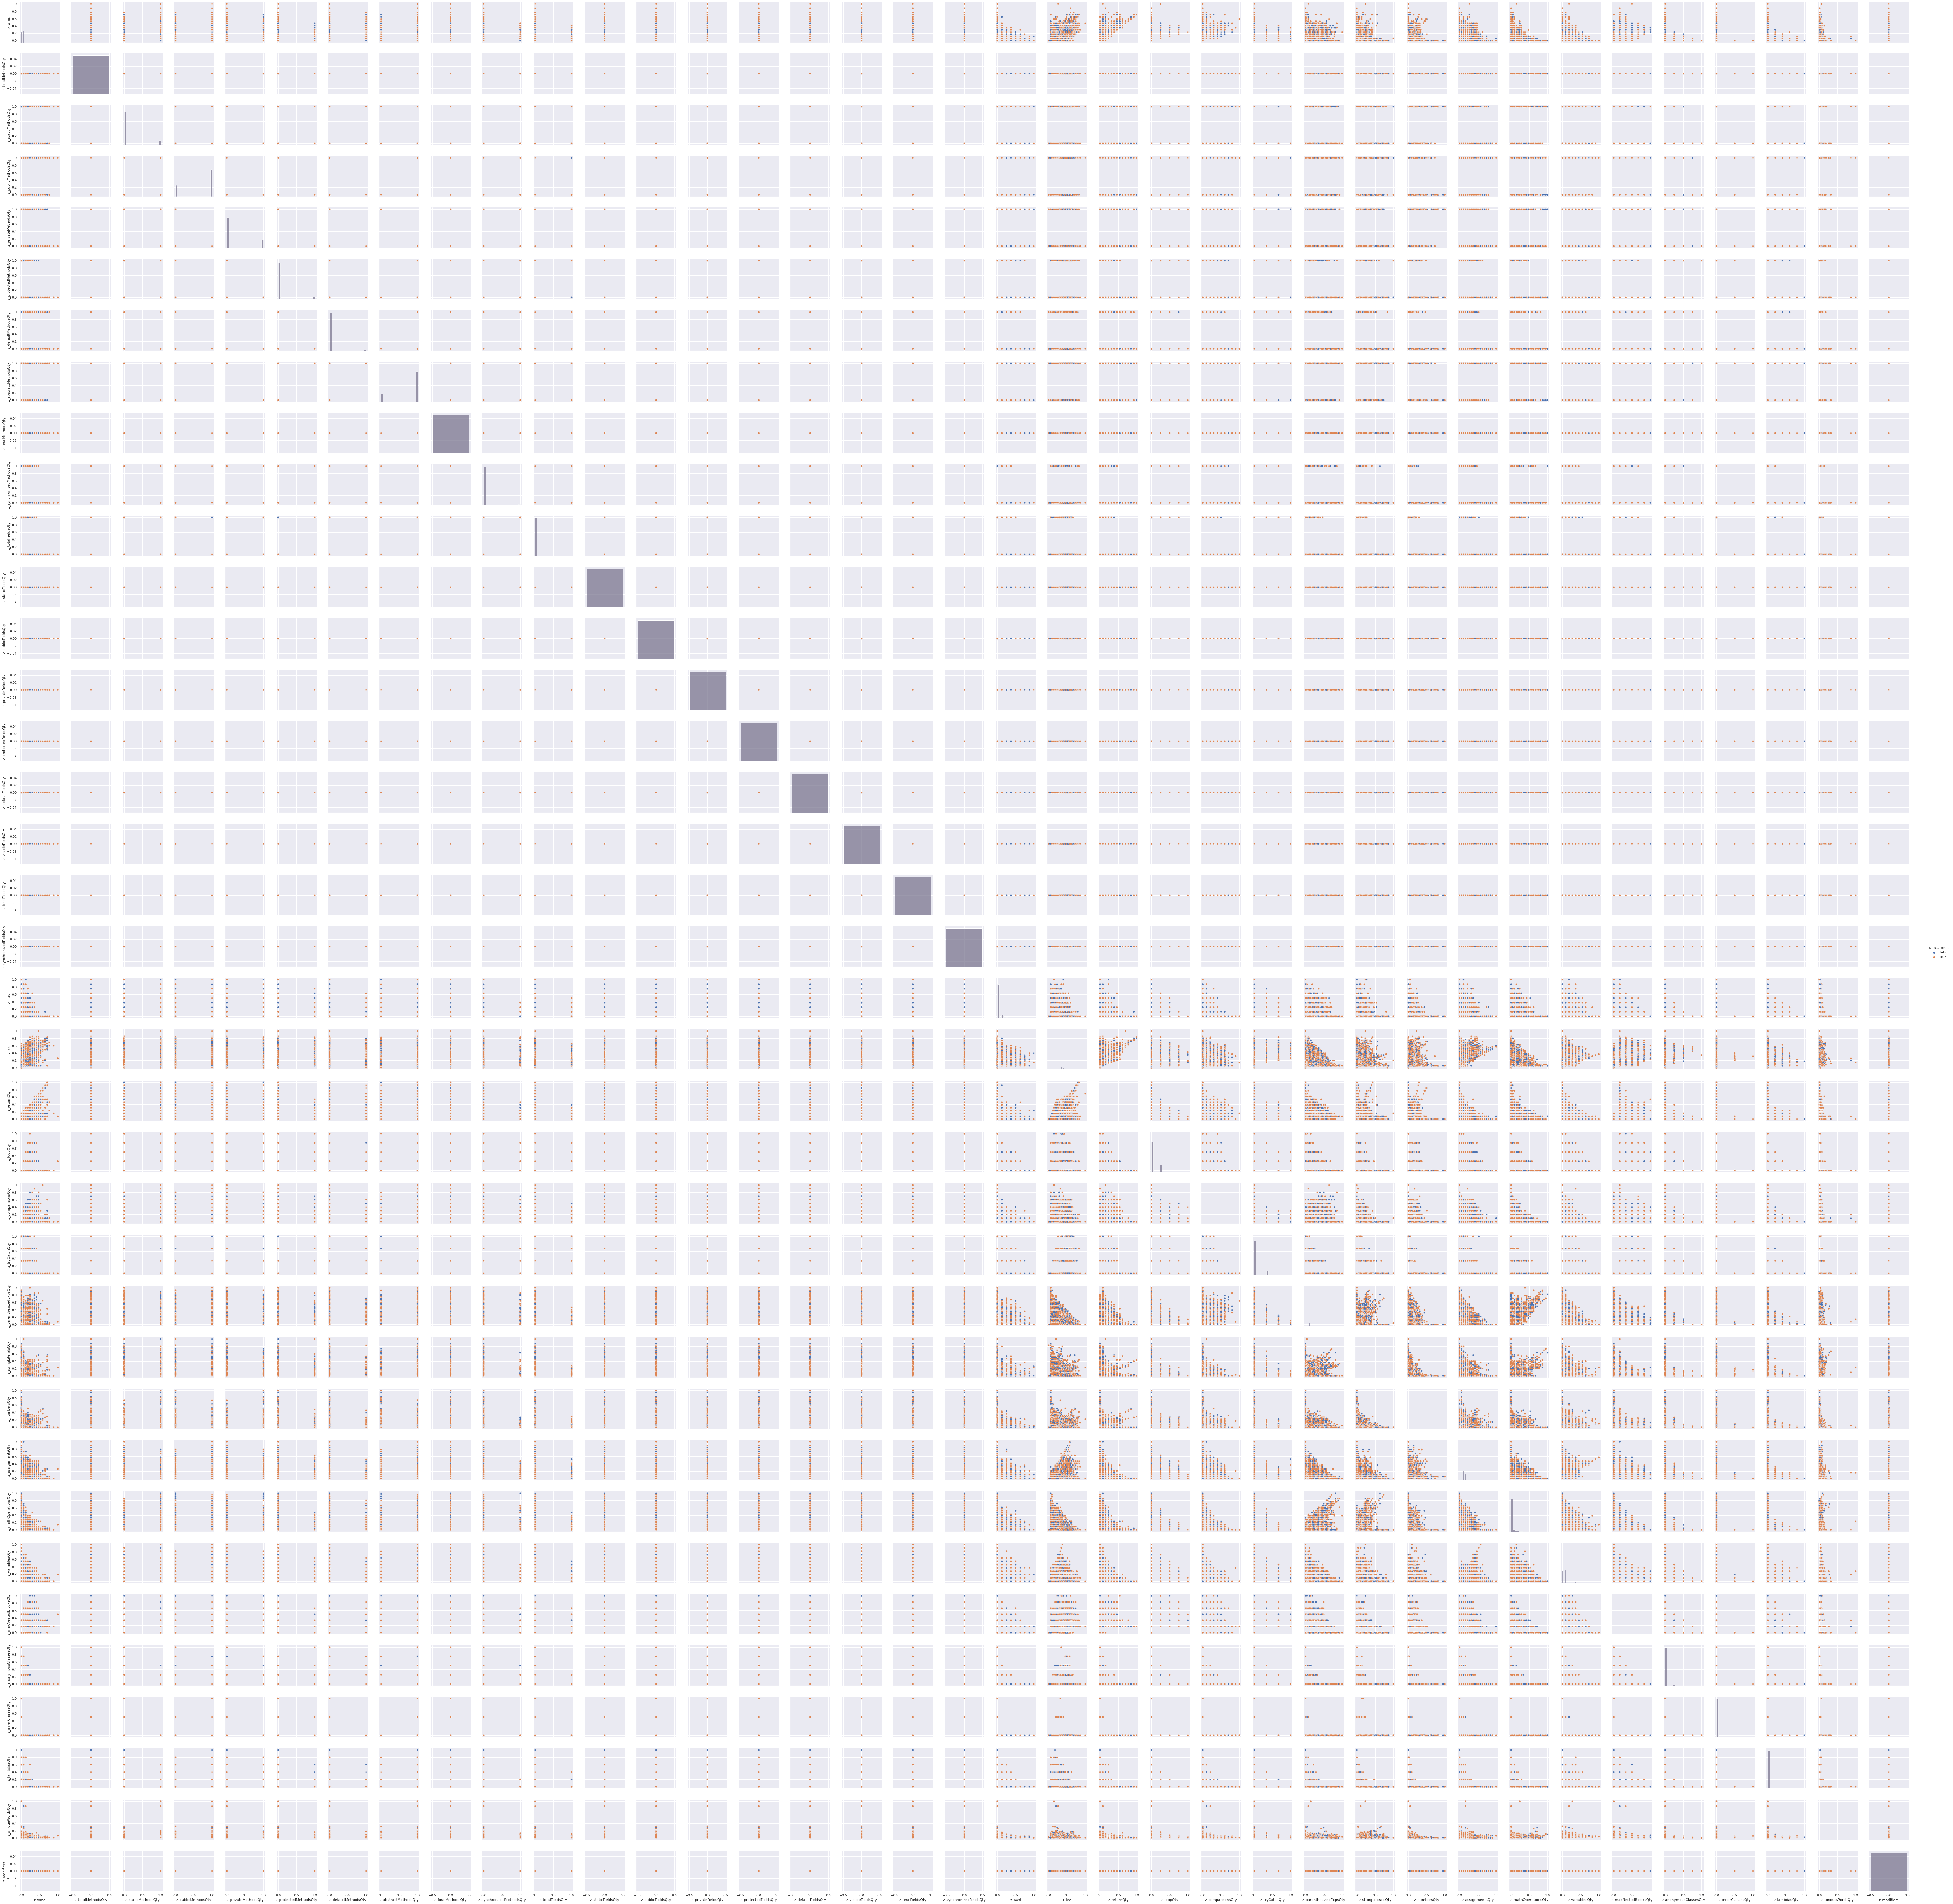

In [175]:
#second covariate by treatment
#WARNING! Takes a lot of time
sns.set_theme(style="darkgrid")

g = sns.PairGrid(df_cross_v1_base_scaled, hue="x_treatment")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4e5d9ebb50>,
      dtype=object)

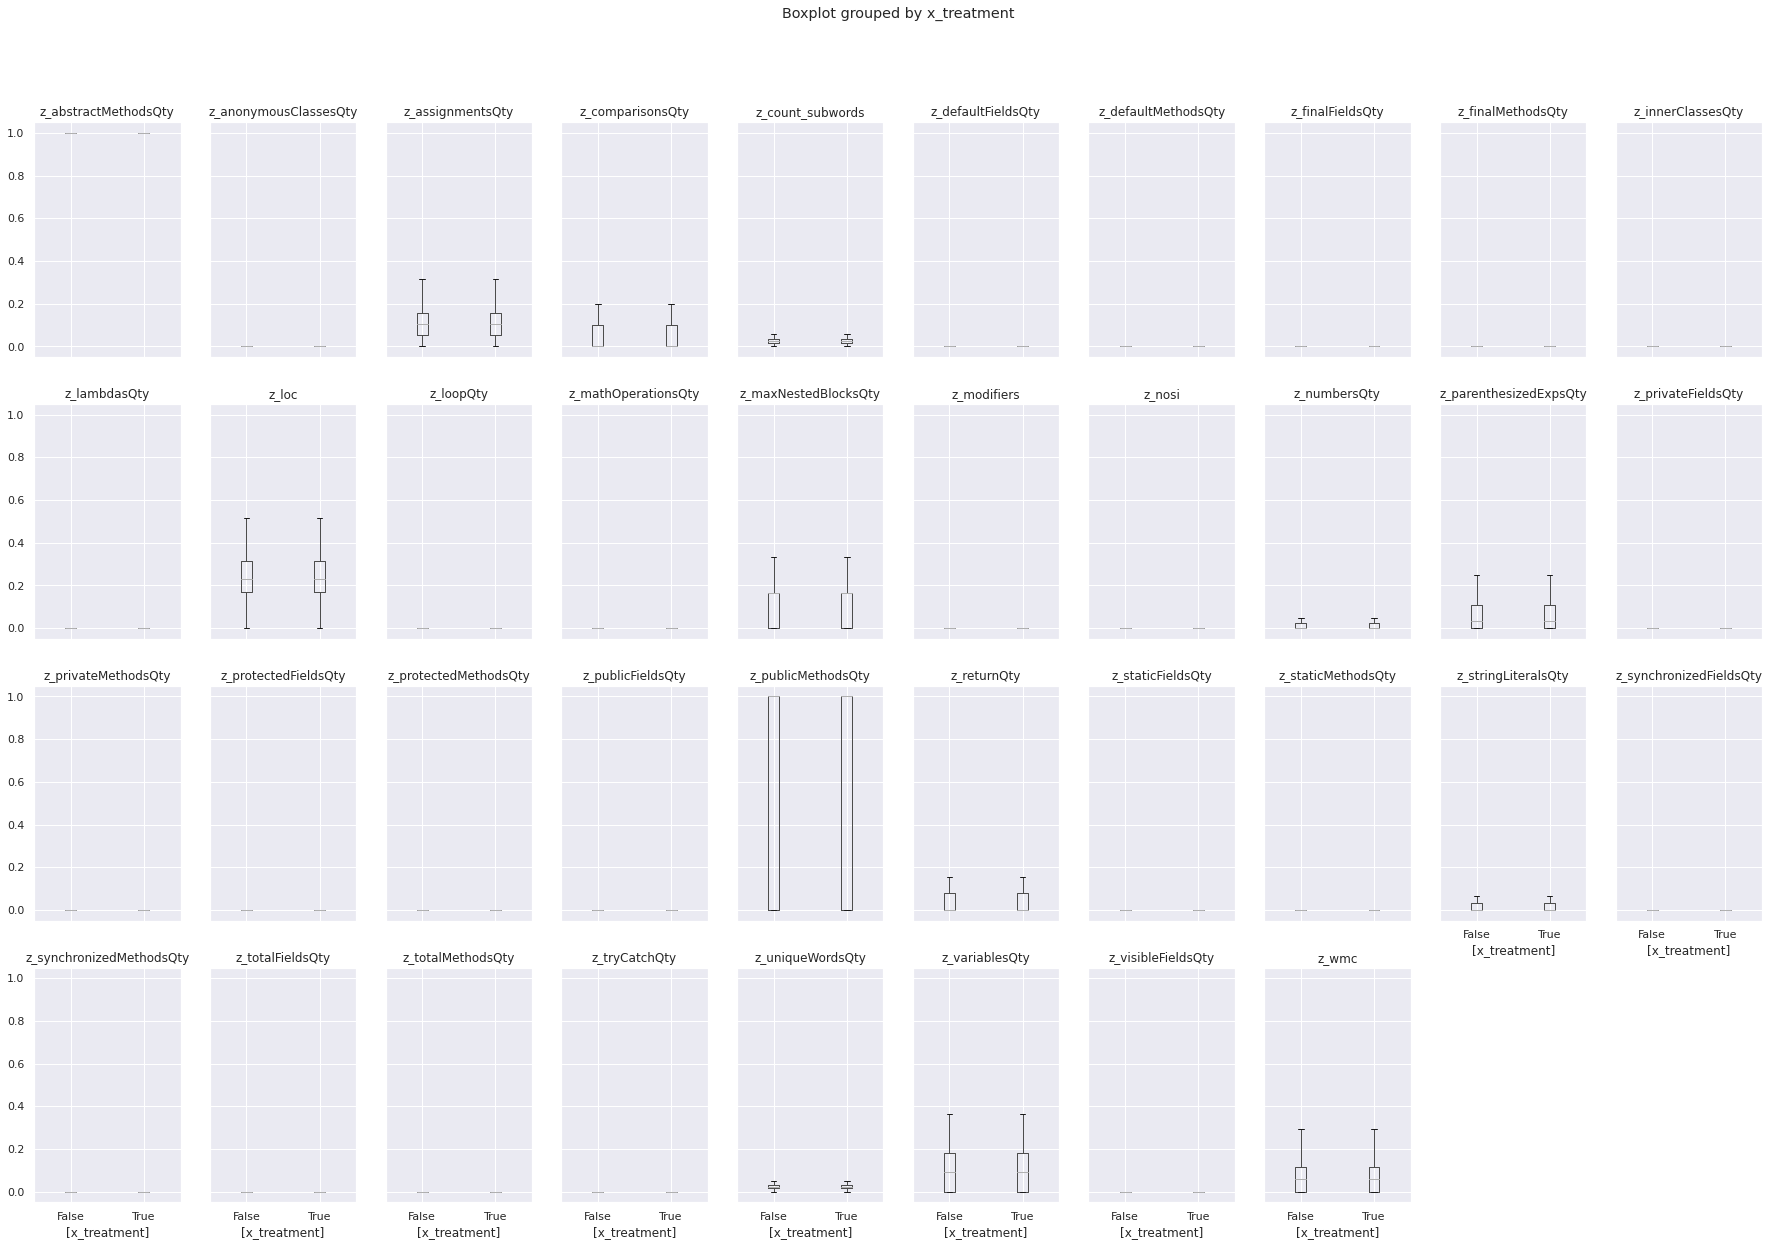

In [370]:
#second covariate by treatment
sns.set_theme(style="darkgrid")

df_error_tax_normalized[covariates+['x_treatment']].boxplot( 
    by='x_treatment',
    showfliers=False,
    layout=(4, 10),
    figsize = (30,20)
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4ed3da9040>,
      dtype=object)

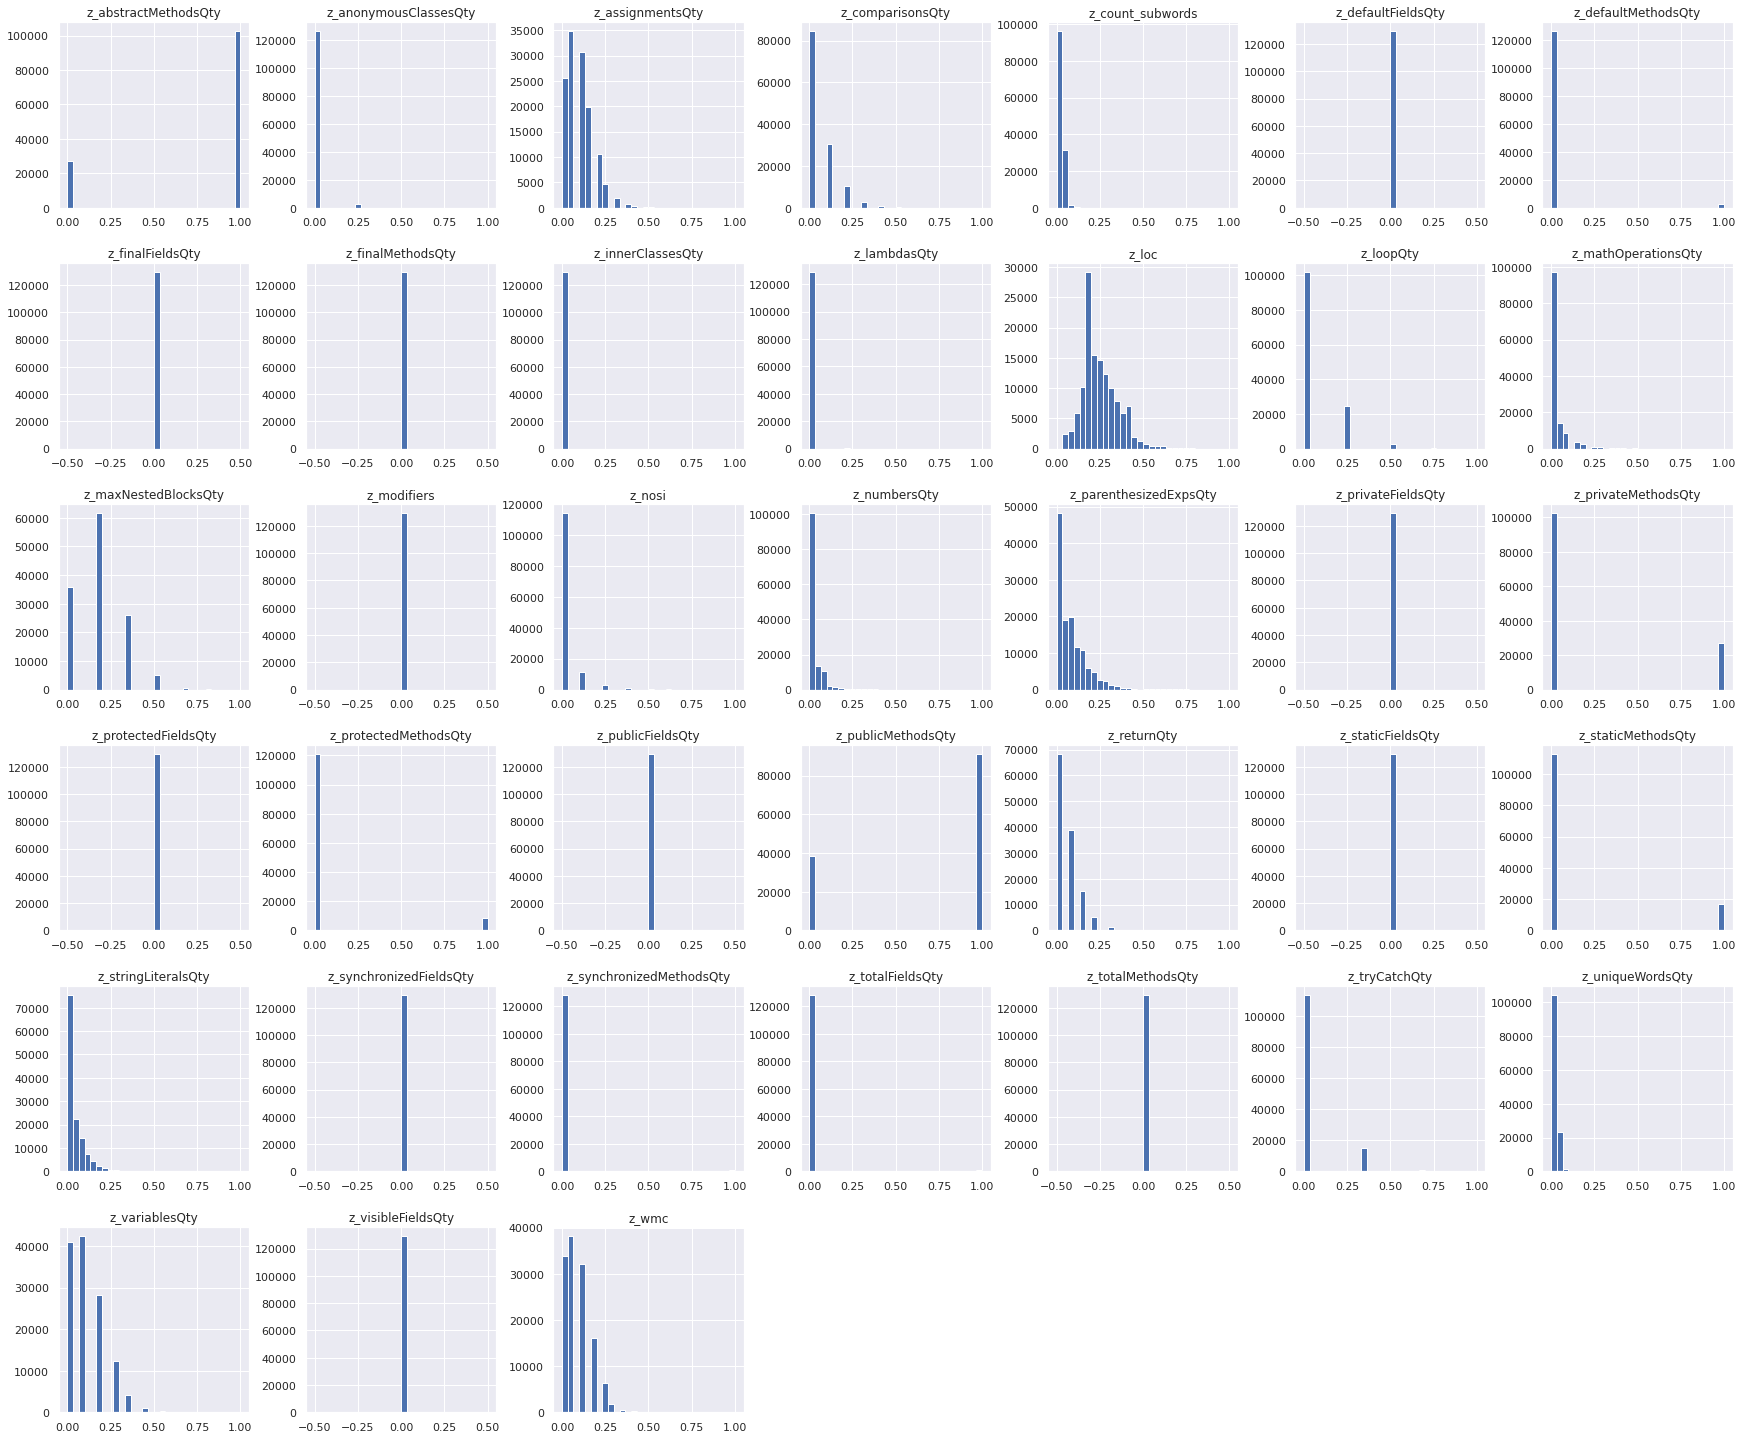

In [371]:
sns.set_theme(style="darkgrid")
df_error_tax_normalized[ covariates ].hist( 
    bins=30,
    #showfliers=False,
    layout=(7, 7),
    figsize = (30,30)
)

In [375]:
#General Correlation
for i in covariates+potential_outcomes_cross:
    df_temp = df_cross_normalized
    #df_temp = df_cross_v1_base[[i,'y_cross_entropy']].dropna(axis=0, how='any') #Clearning nans
    logging.info( str(i)+':' + str( corrcoef(df_temp[i].values, df_temp.y_cross_entropy.values) ) )

2021-07-18 04:30:07,183 : INFO : z_wmc:-0.054
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
2021-07-18 04:30:07,188 : INFO : z_totalMethodsQty:nan
2021-07-18 04:30:07,189 : INFO : z_staticMethodsQty:0.072
2021-07-18 04:30:07,191 : INFO : z_publicMethodsQty:0.021
2021-07-18 04:30:07,192 : INFO : z_privateMethodsQty:-0.031
2021-07-18 04:30:07,193 : INFO : z_protectedMethodsQty:0.023
2021-07-18 04:30:07,195 : INFO : z_defaultMethodsQty:-0.018
2021-07-18 04:30:07,197 : INFO : z_abstractMethodsQty:0.031
2021-07-18 04:30:07,199 : INFO : z_finalMethodsQty:nan
2021-07-18 04:30:07,201 : INFO : z_synchronizedMethodsQty:-0.005
2021-07-18 04:30:07,203 : INFO : z_totalFieldsQty:-0.005
2021-07-18 04:30:07,204 : INFO : z_staticFieldsQty:nan
2021-0

In [360]:
#TODO replace with normalized version above
#df_buggy_cross_v1_base = df_cross_v1_base.loc[lambda row: row['x_treatment'] == True  ].copy()
#df_nonbuggy_cross_v1_base = df_cross_v1_base.loc[lambda row: row['x_treatment'] == False  ].copy()

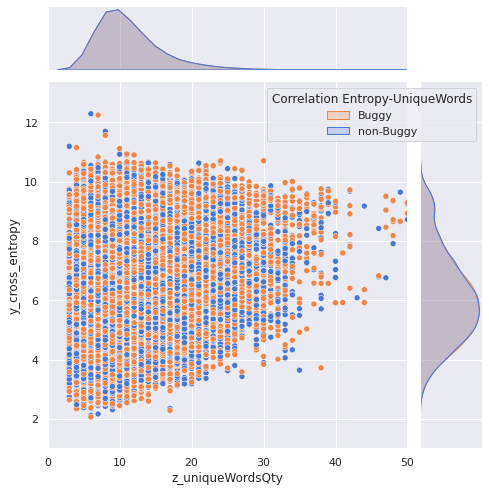

In [184]:
sns.set_theme(style="darkgrid")
o = sns.jointplot(
    x="z_uniqueWordsQty", 
    y="y_cross_entropy", 
    data=df_cross_v1_base,
    hue='x_treatment',
    kind="scatter", 
    #truncate=False,
    xlim=(0, 50), 
    #ylim=(0, 12),
    color="m", 
    palette="muted",
    height=7,
    legend=False
)
plt.legend(
    title="Correlation Entropy-UniqueWords", 
    #loc='upper left', 
    labels=params1['new_labels']
)

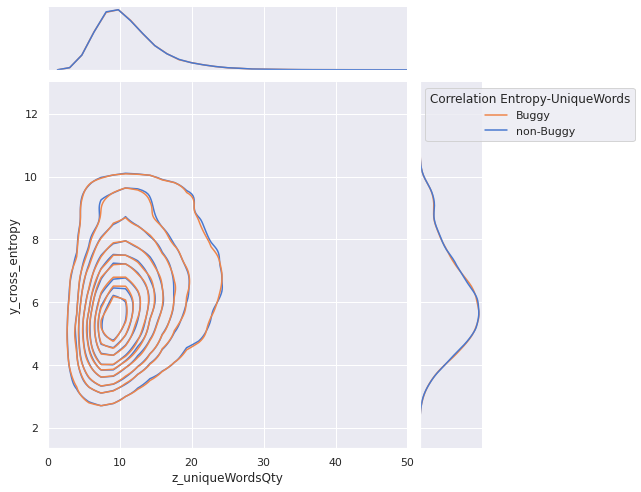

In [185]:
sns.set_theme(style="darkgrid")

o = sns.jointplot(
    x="z_uniqueWordsQty", 
    y="y_cross_entropy", 
    data=df_cross_v1_base,
    hue='x_treatment',
    kind="kde", 
    #truncate=False,
    xlim=(0, 50), 
    #ylim=(0, 12),
    color="m", 
    palette="muted",
    height=7,
    legend=False
)
plt.legend(
    title="Correlation Entropy-UniqueWords", 
    #loc='upper left', 
    labels=params1['new_labels']
)

## Next Token Prediction Analysis

In [375]:
df_error_tax_v1_base.describe()

y_blocks  y_exceptions         y_oop       y_tests  \
count  129444.000000  3.237900e+04  1.280570e+05  7.080000e+02   
mean        0.027398  6.619357e-06  1.560847e-03  2.682235e-06   
std         0.018042  1.147974e-05  3.662612e-03  1.730872e-06   
min         0.000492  1.300000e-09  8.000000e-10  1.842000e-07   
25%         0.013624  8.082000e-07  8.300000e-08  1.641200e-06   
50%         0.024140  1.648700e-06  8.668500e-06  2.242750e-06   
75%         0.037357  8.043200e-06  1.417618e-03  3.153475e-06   
max         0.180986  2.466836e-04  1.678386e-01  1.249600e-05   

       y_declarations  y_conditionals       y_loops   y_operators  \
count    8.949200e+04    7.478600e+04  3.163100e+04  1.238690e+05   
mean     7.849119e-07    1.756289e-05  2.001032e-05  2.942739e-03   
std      9.729956e-06    1.632367e-05  7.926272e-05  1.205765e-02   
min      4.300000e-09    2.500000e-09  7.630000e-08  1.400000e-09   
25%      1.819000e-07    7.591900e-06  4.239600e-06  1.492274e-04   
50%      3.461000e-07    1.201850e-05  9.298200e-06  3.664036e-04   
75%      4.551000e-07    2.195810e-05  1.711530e-05  1.072184e-03   
max      1.013232e-03    5.137535e-04  8.033565e-03  4.924544e-01   

        y_datatypes  y_extra_tokens  ...   z_numbersQty  z_assignmentsQty  \
count  5.470000e+04   129435.000000  ...  129444.000000     129444.000000   
mean   1.386176e-05        0.138973  ...       0.913654          1.884583   
std    3.451656e-05        0.041075  ...       1.720107          1.580910   
min    2.400000e-09        0.000181  ...       0.000000          0.000000   
25%    8.347000e-07        0.111008  ...       0.000000          1.000000   
50%    3.514200e-06        0.137228  ...       0.000000          2.000000   
75%    1.234690e-05        0.164987  ...       1.000000          3.000000   
max    1.900545e-03        0.369389  ...      41.000000         19.000000   

       z_mathOperationsQty  z_variablesQty  z_maxNestedBlocksQty  \
count        129444.000000   129444.000000         129444.000000   
mean              0.571336        1.232247              1.018572   
std               1.363303        1.161180              0.830400   
min               0.000000        0.000000              0.000000   
25%               0.000000        0.000000              0.000000   
50%               0.000000        1.000000              1.000000   
75%               0.000000        2.000000              1.000000   
max              21.000000       11.000000              6.000000   

       z_anonymousClassesQty  z_innerClassesQty   z_lambdasQty  \
count          129444.000000      129444.000000  129444.000000   
mean                0.023122           0.000348       0.006080   
std                 0.157225           0.020232       0.092444   
min                 0.000000           0.000000       0.000000   
25%                 0.000000           0.000000       0.000000   
50%                 0.000000           0.000000       0.000000   
75%                 0.000000           0.000000       0.000000   
max                 4.000000           2.000000       5.000000   

       z_uniqueWordsQty  z_modifiers  
count     129444.000000     129444.0  
mean          11.336732          1.0  
std            4.994894          0.0  
min            3.000000          1.0  
25%            8.000000          1.0  
50%           10.000000          1.0  
75%           13.000000          1.0  
max          336.000000          1.0  

[8 rows x 48 columns]

In [392]:
#TODO change plots for https://seaborn.pydata.org/tutorial/function_overview.html
# https://seaborn.pydata.org/tutorial/distributions.html
CORR_LIMIT = 0.2
#General Correlation
for i in taxonomy:
    for j in appropriate_columns[:-1]:
        df_temp = df_error_tax_v1_base
        #df_temp = df_error_tax_v1_base[[i,j]].dropna(axis=0, how='any')
        correlation = corrcoef(df_temp[i].values, df_temp[j].values)
        if np.absolute(correlation) >= CORR_LIMIT:
            logging.info( '['+ str(i) +'] - ['+ str(j) +']'+':' + str( correlation ) )

2021-07-08 19:33:32,854 : INFO : [y_blocks] - [z_loc]:-0.418
2021-07-08 19:33:32,858 : INFO : [y_blocks] - [z_tryCatchQty]:-0.213
2021-07-08 19:33:32,860 : INFO : [y_blocks] - [z_parenthesizedExpsQty]:0.466
2021-07-08 19:33:32,864 : INFO : [y_blocks] - [z_mathOperationsQty]:0.274
2021-07-08 19:33:32,866 : INFO : [y_blocks] - [z_maxNestedBlocksQty]:-0.222


In [386]:
df_buggy_error_tax_v1_base = df_error_tax_v1_base.loc[lambda row: row['x_treatment'] == True  ].copy()
df_nonbuggy_error_tax_v1_base = df_error_tax_v1_base.loc[lambda row: row['x_treatment'] == False  ].copy()

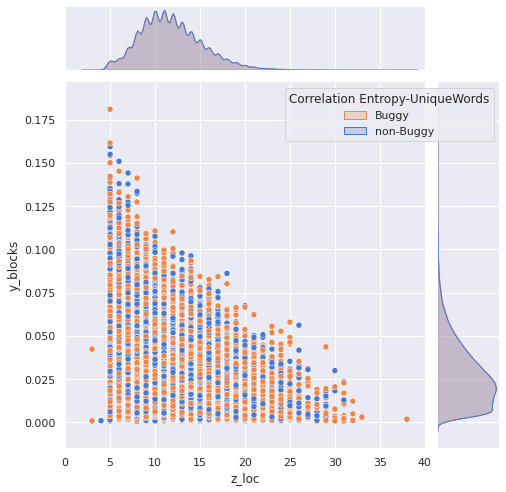

In [192]:
sns.set_theme(style="darkgrid")

o = sns.jointplot(
    x="z_loc", 
    y="y_blocks", 
    data=df_error_tax_v1_base,
    hue='x_treatment',
    kind="scatter", 
    #truncate=False,
    xlim=(0, 40), 
    #ylim=(0, 12),
    color="m", 
    palette="muted",
    height=7,
    legend=False
)
plt.legend(
    title="Correlation Blocks-Loc", 
    #loc='upper left', 
    labels=params1['new_labels']
)

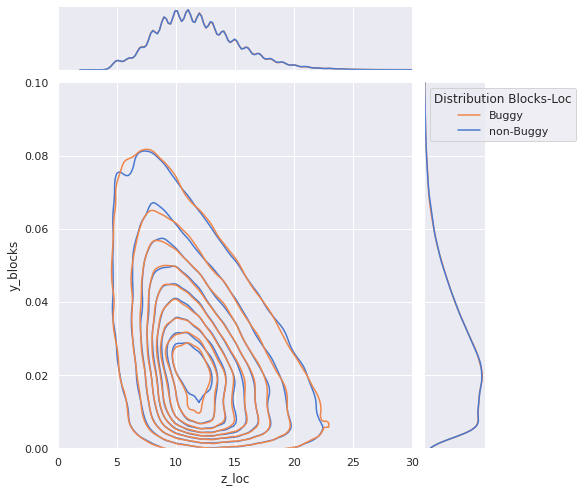

In [195]:
sns.set_theme(style="darkgrid")

o = sns.jointplot(
    x="z_loc", 
    y="y_blocks", 
    data=df_error_tax_v1_base,
    hue='x_treatment',
    kind="kde", 
    #truncate=False,
    xlim=(0, 30), 
    ylim=(0, 0.1),
    color="m", 
    palette="muted",
    height=7,
    legend=False
)
#o.plot_marginals(sns.boxplot)

plt.legend(
    title="Distribution Blocks-Loc", 
    #loc='upper left', 
    labels=params1['new_labels']
)

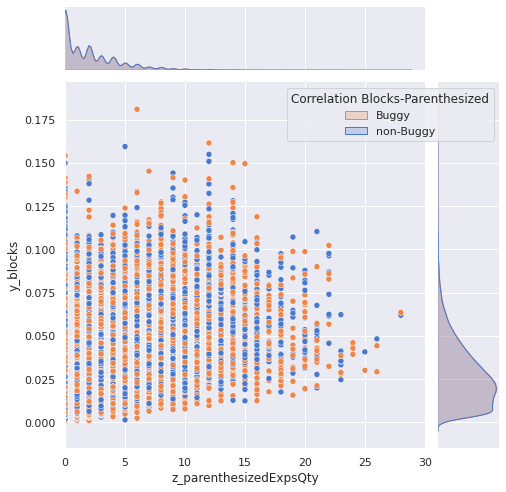

In [196]:
#An Example with z_parenthesizedExpsQty due to the correlation with y_blocks
sns.set_theme(style="darkgrid")

o = sns.jointplot(
    x="z_parenthesizedExpsQty", 
    y="y_blocks", 
    data=df_error_tax_v1_base,
    hue='x_treatment',
    kind="scatter", 
    #truncate=False,
    xlim=(0, 30), 
    #ylim=(0, 12),
    color="m", 
    palette="muted",
    height=7,
    legend=False
)
plt.legend(
    title="Correlation Blocks-Parenthesized", 
    #loc='upper left', 
    labels=params1['new_labels']
)

In [198]:
sns.set_theme(style="darkgrid")

o = sns.jointplot(
    x="z_parenthesizedExpsQty", 
    y="y_blocks", 
    data=df_error_tax_v1_base,
    hue='x_treatment',
    kind="kde", 
    #truncate=False,
    xlim=(0, 30), 
    ylim=(0, 0.1),
    color="m", 
    palette="muted",
    height=7,
    legend=False
)
plt.legend(
    title="Correlation Blocks-Parenthesized", 
    #loc='upper left', 
    labels=params1['new_labels']
)